# トヨタ株 (TM) — 翌日終値予測 + 売買判断（Buy/Sell）

**目的**: 2020/09〜2025/06 の株価データを用い、  
1) 翌日の終値を**回帰**で予測し、  
2) その予測に基づいて**売買判断（Buy/Sell）**の**分類**を行う。

**ポイント**  
- ローカルCSVファイル (`data/TM_1980-01-01_2025-06-27.csv`) から直接データを読み込み
- **標準LSTM** と **改良LSTM**（BiLSTM, AdamW, Huber Loss）の2つのモデルを比較
- ベースライン（線形回帰）と比較、さらに**指標可視化**、**単純バックテスト**を実装
- 包括的な可視化機能により、データ・学習・予測・取引戦略を多角的に分析

---

## ⚠️ 重要：実行順序について

**このノートブックは必ず上から順番に実行してください。**

### 基本的な実行フロー：

1. **Imports** → ライブラリの読み込み
2. **Parameters** → ハイパーパラメータ設定
3. **データ読み込み関数** → CSV読み込み関数定義
4. **データ取得** → データ読み込みとpickle保存
5. **データ可視化** → (オプション)
6. **特徴量生成** → テクニカル指標計算
7. **テクニカル指標可視化** → (オプション)
8. **🔴 時系列分割** → **重要！** スケーラー (`scaler_X`, `scaler_y`) とデータセットを作成
9. **データ分割可視化** → (オプション)
10. **ベースライン学習** → セル8の実行が必須
11. **標準LSTM学習** → セル8の実行が必須
12. **🆕 改良LSTM学習** → セル8, 11の実行が必須
13. **予測結果可視化** → (オプション)
14. **🔴 分類（Buy/Sell判定）** → **重要！** `close_test_tail`などを定義
15. **🆕 改良LSTMの分類・バックテスト** → セル14の実行が必須
16. **分類性能可視化** → (オプション)
17. **バックテスト** → セル14の実行が必須
18. **保存** → モデルとスケーラーの保存
19. **総合サマリー** → 全モデルの比較

### ⚠️ エラーが出たら

- `NameError: name 'xxx' is not defined` → 上のセルを飛ばしています
- 特に**セル8（時系列分割）**と**セル14（分類）**は必須
- `Kernel → Restart & Run All` で全セル再実行を推奨

セルを飛ばして実行すると `NameError` が発生します。

In [1]:
# === Imports ===
import os
import sys
import math
import gc
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from datetime import datetime

# Plot
import matplotlib.pyplot as plt

# ML/DL
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print('TensorFlow:', tf.__version__)
print('All imports successful!')

TensorFlow: 2.20.0
All imports successful!


In [2]:
# === Parameters ===
TICKER = "TM"      # トヨタ自動車 (NYSE: TM)
START_DATE = "1980-03-17"
END_DATE   = "2025-06-27"  # データセットの最終日に合わせる

# 学習ハイパラ
WINDOW_SIZE = 20     # 何日分の履歴で翌日を予測するか
BATCH_SIZE  = 32
EPOCHS      = 30
VAL_SPLIT   = 0.0     # 明示的に時系列分割するので 0

# 時系列分割（固定境界）
SPLIT_TRAIN_END = "2024-03-31"
SPLIT_VAL_END   = "2025-03-31"  # val: 2024-04-01〜2025-03-31
# test: 2025-04-01〜2025-06-27

# 乱数シード
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# === データ読み込み関数 ===
def load_csv_data(csv_path):
    """
    ローカルCSVファイルから株価データを読み込む
    """
    df = pd.read_csv(csv_path)
    
    # CSV の2行目がティッカー名のみの場合は削除
    if len(df) > 0 and df.iloc[0].isna().all():
        df = df.iloc[1:].reset_index(drop=True)
    
    # date列を探す
    candidate_date_cols = [c for c in df.columns if str(c).strip().lower() in {'date', 'datetime'}]
    if candidate_date_cols:
        date_col = candidate_date_cols[0]
        # 日付として変換できない行を削除
        df = df[pd.to_datetime(df[date_col], errors='coerce').notna()]
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.set_index(date_col)
    else:
        # 先頭列が日付と想定
        first_col = df.columns[0]
        df = df[pd.to_datetime(df[first_col], errors='coerce').notna()]
        df[first_col] = pd.to_datetime(df[first_col])
        df = df.set_index(first_col)
    
    # 数値列として扱えるようにする
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(how='all')
    
    # インデックスに欠損がある行を削除
    df = df[df.index.notna()]
    df = df.sort_index()
    
    # 列名を小文字に揃える
    cols = {c: str(c).lower().replace(' ', '').replace('_', '') for c in df.columns}
    df = df.rename(columns=cols)
    
    # 必須列があるかチェック
    must = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
    for m in must:
        if m not in df.columns:
            # adjclose がないケースもあるので Close を複製
            if m == 'adjclose' and 'close' in df.columns:
                df['adjclose'] = df['close']
            else:
                raise ValueError(f"Missing column: {m}")
    
    return df[['open','high','low','close','adjclose','volume']]

print('Data loading function defined.')

Data loading function defined.


In [4]:
# === データ取得 ===
CSV_PATH = "data/TM_1980-01-01_2025-06-27.csv"

df = load_csv_data(CSV_PATH)

print('Data loaded successfully!')
print(f'Shape: {df.shape}')
print(f'Date range: {df.index.min()} to {df.index.max()}')
print('\nFirst few rows:')
print(df.head())
print('\nLast few rows:')
print(df.tail())
print('\nData statistics:')
print(df.describe())

# 保存（チュートリアル互換）
df.to_pickle('df_ohlcv_7203T.pkl')
print('\nData saved to df_ohlcv_7203T.pkl')

Data loaded successfully!
Shape: (11413, 6)
Date range: 1980-03-17 00:00:00 to 2025-06-26 00:00:00

First few rows:
                open      high       low     close  adjclose  volume
date                                                                
1980-03-17  0.000000  3.344743  3.291227  3.291227  1.848979   41109
1980-03-18  0.000000  3.358122  3.304606  3.304606  1.856495    9343
1980-03-19  3.304606  3.304606  3.304606  3.304606  1.856495       0
1980-03-20  0.000000  3.358122  3.304606  3.304606  1.856495   10277
1980-03-21  0.000000  3.438396  3.384880  3.384880  1.901592    8409

Last few rows:
                  open        high         low       close    adjclose  volume
date                                                                          
2025-06-20  173.300003  173.360001  171.889999  172.399994  172.399994  469300
2025-06-23  170.050003  171.050003  169.199997  170.880005  170.880005  622800
2025-06-24  171.800003  172.389999  171.509995  171.580002  171.58000

In [7]:
# === 期間フィルタ（念のため） ===
# dfが存在することを確認
if 'df' not in dir():
    fallback_path = Path('df_ohlcv_7203T.pkl')
    if fallback_path.exists():
        df = pd.read_pickle(fallback_path)
        print(f"Loaded cached OHLCV data from {fallback_path}")
    else:
        raise RuntimeError('価格データ(df)が存在しません。先にデータ取得セルを実行するか df_ohlcv_7203T.pkl を用意してください。')

df = df[(df.index >= pd.to_datetime(START_DATE)) & (df.index <= pd.to_datetime(END_DATE))].copy()
print(f'Filtered data shape: {df.shape}')

# === テクニカル指標・派生特徴量 ===
def rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=period, min_periods=period).mean()
    ma_down = down.rolling(window=period, min_periods=period).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

def macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def bollinger(series, window=20, num_std=2):
    ma = series.rolling(window=window, min_periods=window).mean()
    std = series.rolling(window=window, min_periods=window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    width = (upper - lower) / (ma + 1e-9)
    return ma, upper, lower, width

# 主要な終値ベースで算出
close = df['close']

df['ret_1d'] = close.pct_change()
df['ma_7']   = close.rolling(7).mean()
df['ma_30']  = close.rolling(30).mean()
df['ema_7']  = close.ewm(span=7, adjust=False).mean()
df['ema_30'] = close.ewm(span=30, adjust=False).mean()
df['rsi_14'] = rsi(close, 14)

macd_line, signal_line, macd_hist = macd(close)
df['macd']   = macd_line
df['macd_s'] = signal_line
df['macd_h'] = macd_hist

bb_ma, bb_up, bb_lo, bb_w = bollinger(close, 20, 2)
df['bb_ma'] = bb_ma
df['bb_up'] = bb_up
df['bb_lo'] = bb_lo
df['bb_w']  = bb_w

# 出来高系
df['vol_chg'] = df['volume'].pct_change()

# 1日先の終値（回帰ターゲット）
df['target_close_t1'] = df['close'].shift(-1)

# 1日先が上昇なら1（Buy）、下降なら0（Sell）
df['target_buy'] = (df['target_close_t1'] > df['close']).astype(float)

# 欠損除去
df = df.dropna().copy()
print('Final shape with features:', df.shape)
print('\nFirst few rows with features:')
print(df.head(3))
display(df)

Filtered data shape: (11369, 22)
Final shape with features: (11339, 22)

First few rows with features:
                open      high       low     close  adjclose  volume  \
date                                                                   
1980-06-09  0.000000  4.093966  4.040450  4.040450  2.269885    8409   
1980-06-10  0.000000  4.107345  4.053829  4.053829  2.277401    2803   
1980-06-11  4.053829  4.053829  4.053829  4.053829  2.277401       0   

              ret_1d      ma_7     ma_30     ema_7  ...      macd    macd_s  \
date                                                ...                       
1980-06-09  0.010034  3.979289  3.856712  3.988433  ...  0.073441  0.075102   
1980-06-10  0.003311  3.994579  3.872321  4.004782  ...  0.075172  0.075116   
1980-06-11  0.000000  4.007958  3.886146  4.017044  ...  0.075672  0.075228   

              macd_h     bb_ma     bb_up     bb_lo      bb_w   vol_chg  \
date                                                              

,open,high,low,close,adjclose,volume,ret_1d,ma_7,ma_30,ema_7,...,macd,macd_s,macd_h,bb_ma,bb_up,bb_lo,bb_w,vol_chg,target_close_t1,target_buy
date,,,,,,,,,,,,,,,,,,,,,
1980-06-09,0.000000,4.093966,4.040450,4.040450,2.269885,8409,0.010034,3.979289,3.856712,3.988433,...,0.073441,0.075102,-0.001661,3.933418,4.059523,3.807313,0.064120,2.000000,4.053829,1.0
1980-06-10,0.000000,4.107345,4.053829,4.053829,2.277401,2803,0.003311,3.994579,3.872321,4.004782,...,0.075172,0.075116,0.000056,3.942114,4.076403,3.807825,0.068130,-0.666667,4.053829,0.0
1980-06-11,4.053829,4.053829,4.053829,4.053829,2.277401,0,0.000000,4.007958,3.886146,4.017044,...,0.075672,0.075228,0.000445,3.950811,4.090552,3.811069,0.070741,-1.000000,4.067208,1.0
1980-06-16,0.000000,4.120724,4.067208,4.067208,2.284917,7474,0.003300,4.023248,3.899971,4.029585,...,0.076269,0.075436,0.000833,3.960176,4.104925,3.815427,0.073102,inf,4.040450,0.0
1980-06-17,0.000000,4.093966,4.040450,4.040450,2.269885,934,-0.006579,4.032805,3.912458,4.032301,...,0.073732,0.075095,-0.001363,3.968203,4.112012,3.824395,0.072480,-0.875033,4.040450,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,175.520004,175.520004,173.449997,173.949997,173.949997,555400,-0.020938,180.594286,185.547334,179.666252,...,-1.955933,-0.585939,-1.369994,184.219501,192.675655,175.763346,0.091805,0.280314,175.589996,1.0
2025-06-18,176.449997,177.440002,175.589996,175.589996,175.589996,458600,0.009428,179.401428,184.986001,178.647188,...,-2.296295,-0.928011,-1.368284,183.681001,192.900466,174.461535,0.100386,-0.174289,172.399994,0.0
2025-06-20,173.300003,173.360001,171.889999,172.399994,172.399994,469300,-0.018167,177.565713,184.436001,177.085389,...,-2.791264,-1.300661,-1.490603,183.077500,193.571583,172.583417,0.114641,0.023332,170.880005,0.0


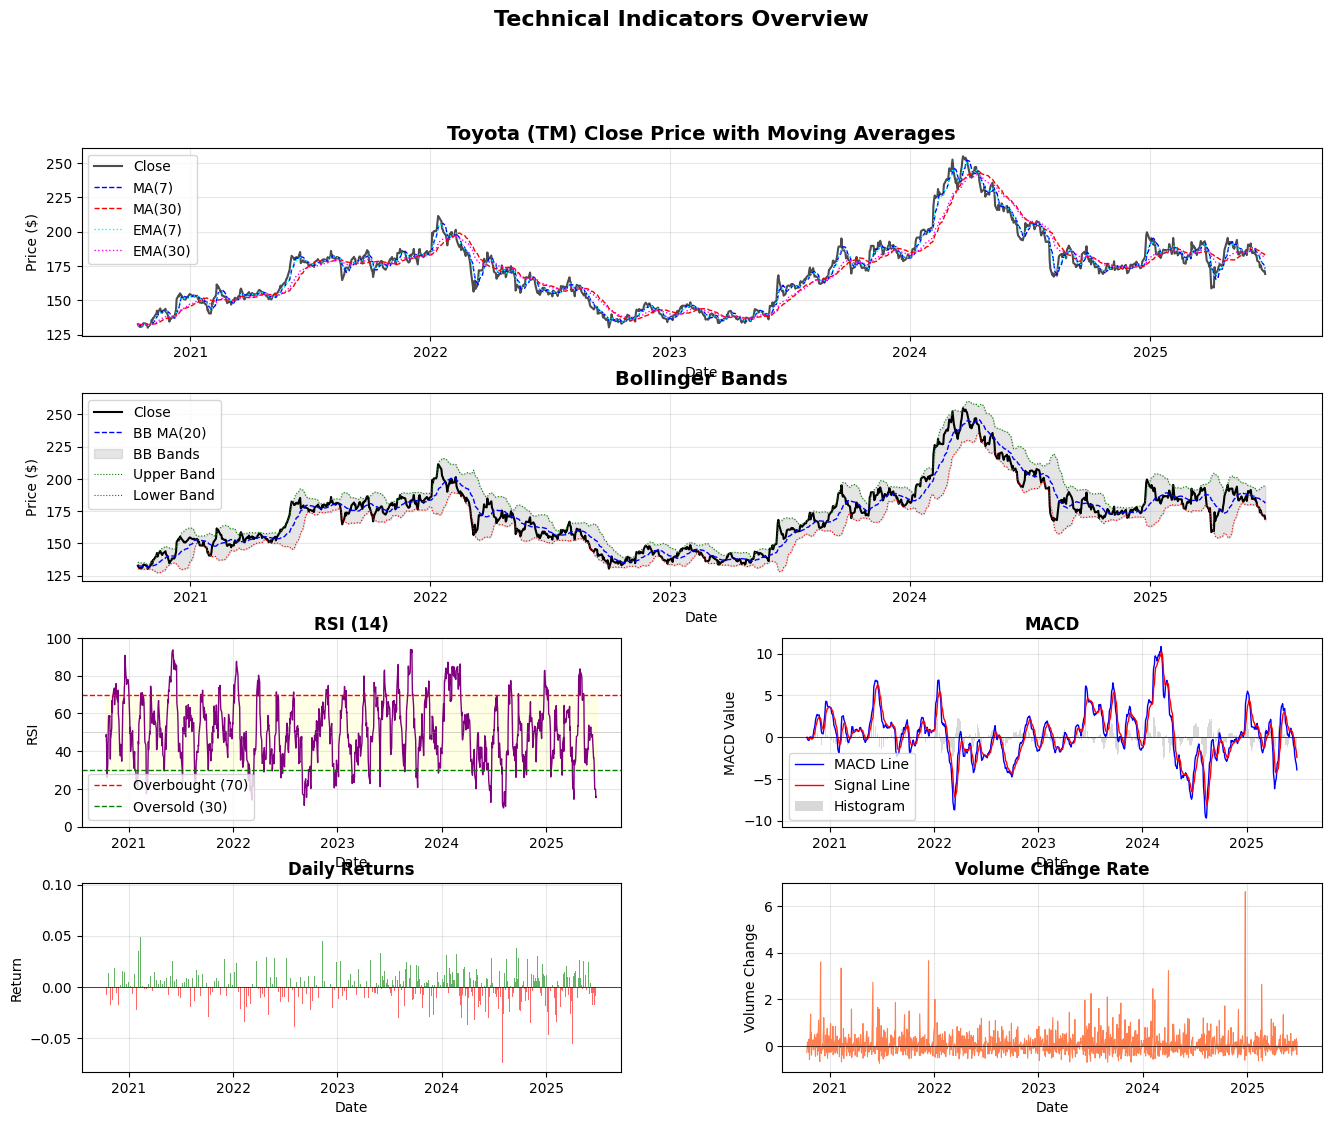

Technical indicators visualization complete!


In [7]:
# === テクニカル指標の詳細可視化 ===
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# 1. 終値 + 移動平均線
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df.index, df['close'], label='Close', linewidth=1.5, color='black', alpha=0.7)
ax1.plot(df.index, df['ma_7'], label='MA(7)', linewidth=1, linestyle='--', color='blue')
ax1.plot(df.index, df['ma_30'], label='MA(30)', linewidth=1, linestyle='--', color='red')
ax1.plot(df.index, df['ema_7'], label='EMA(7)', linewidth=1, linestyle=':', color='cyan')
ax1.plot(df.index, df['ema_30'], label='EMA(30)', linewidth=1, linestyle=':', color='magenta')
ax1.set_title('Toyota (TM) Close Price with Moving Averages', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# 2. ボリンジャーバンド
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(df.index, df['close'], label='Close', linewidth=1.5, color='black')
ax2.plot(df.index, df['bb_ma'], label='BB MA(20)', linewidth=1, linestyle='--', color='blue')
ax2.fill_between(df.index, df['bb_up'], df['bb_lo'], alpha=0.2, color='gray', label='BB Bands')
ax2.plot(df.index, df['bb_up'], linewidth=0.8, linestyle=':', color='green', label='Upper Band')
ax2.plot(df.index, df['bb_lo'], linewidth=0.8, linestyle=':', color='red', label='Lower Band')
ax2.set_title('Bollinger Bands', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price ($)')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# 3. RSI
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(df.index, df['rsi_14'], linewidth=1, color='purple')
ax3.axhline(70, linestyle='--', color='red', linewidth=1, label='Overbought (70)')
ax3.axhline(30, linestyle='--', color='green', linewidth=1, label='Oversold (30)')
ax3.axhline(50, linestyle='-', color='gray', linewidth=0.5, alpha=0.5)
ax3.fill_between(df.index, 30, 70, alpha=0.1, color='yellow')
ax3.set_title('RSI (14)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('RSI')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 100)

# 4. MACD
ax4 = fig.add_subplot(gs[2, 1])
ax4.plot(df.index, df['macd'], label='MACD Line', linewidth=1, color='blue')
ax4.plot(df.index, df['macd_s'], label='Signal Line', linewidth=1, color='red')
ax4.bar(df.index, df['macd_h'], label='Histogram', alpha=0.3, color='gray', width=1)
ax4.axhline(0, linestyle='-', color='black', linewidth=0.5)
ax4.set_title('MACD', fontsize=12, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('MACD Value')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# 5. 日次リターン
ax5 = fig.add_subplot(gs[3, 0])
colors = ['green' if x > 0 else 'red' for x in df['ret_1d']]
ax5.bar(df.index, df['ret_1d'], color=colors, alpha=0.6, width=1)
ax5.axhline(0, linestyle='-', color='black', linewidth=0.5)
ax5.set_title('Daily Returns', fontsize=12, fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('Return')
ax5.grid(True, alpha=0.3)

# 6. 出来高変化率
ax6 = fig.add_subplot(gs[3, 1])
ax6.plot(df.index, df['vol_chg'], linewidth=0.8, color='coral')
ax6.axhline(0, linestyle='-', color='black', linewidth=0.5)
ax6.set_title('Volume Change Rate', fontsize=12, fontweight='bold')
ax6.set_xlabel('Date')
ax6.set_ylabel('Volume Change')
ax6.grid(True, alpha=0.3)

plt.suptitle('Technical Indicators Overview', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("Technical indicators visualization complete!")

In [8]:
# === 時系列分割 ===
# 注意: このセルを実行すると、以下の重要な変数が作成されます：
# - scaler_X, scaler_y (スケーラー)
# - y_train_reg_scaled, y_val_reg_scaled, y_test_reg_scaled (スケーリング済みターゲット)
# - y_train_reg, y_val_reg, y_test_reg (元のスケールのターゲット)
# このセルを実行せずに後続のセルを実行するとエラーになります。

train = df[df.index <= SPLIT_TRAIN_END].copy()
val   = df[(df.index > SPLIT_TRAIN_END) & (df.index <= SPLIT_VAL_END)].copy()
test  = df[df.index > SPLIT_VAL_END].copy()

print('train:', train.index.min(), '->', train.index.max(), len(train))
print('val  :', val.index.min(),   '->', val.index.max(),   len(val))
print('test :', test.index.min(),  '->', test.index.max(),  len(test))

# 特徴量カラム
FEATURE_COLS = [
    'open','high','low','close','adjclose','volume',
    'ret_1d','ma_7','ma_30','ema_7','ema_30','rsi_14',
    'macd','macd_s','macd_h','bb_ma','bb_up','bb_lo','bb_w','vol_chg'
]

def make_window_dataset(df_part, feature_cols, target_col, window):
    X_list, y_list = [], []
    feats = df_part[feature_cols].values
    target = df_part[target_col].values
    for i in range(len(df_part) - window):
        X_list.append(feats[i:i+window])
        y_list.append(target[i+window])
    return np.array(X_list), np.array(y_list)

# スケーラーは訓練でfitし、他でtransform
print('\nCreating scalers...')
scaler_X = StandardScaler()
scaler_X.fit(train[FEATURE_COLS].values)

# ターゲット（終値）用のスケーラーも別途作成
scaler_y = StandardScaler()
scaler_y.fit(train[['target_close_t1']].values)
print('✓ Scalers created: scaler_X and scaler_y')

def scale_df(df_part):
    cp = df_part.copy()
    cp[FEATURE_COLS] = scaler_X.transform(cp[FEATURE_COLS].values)
    # ターゲットもスケーリング
    cp['target_close_t1_scaled'] = scaler_y.transform(cp[['target_close_t1']].values)
    return cp

train_s = scale_df(train)
val_s   = scale_df(val)
test_s  = scale_df(test)

# 回帰用データセット（翌日終値） - スケーリング済みターゲットを使用
print('\nCreating window datasets...')
X_train_reg, y_train_reg_scaled = make_window_dataset(train_s, FEATURE_COLS, 'target_close_t1_scaled', WINDOW_SIZE)
X_val_reg,   y_val_reg_scaled   = make_window_dataset(val_s,   FEATURE_COLS, 'target_close_t1_scaled', WINDOW_SIZE)
X_test_reg,  y_test_reg_scaled  = make_window_dataset(test_s,  FEATURE_COLS, 'target_close_t1_scaled', WINDOW_SIZE)

# 元のスケールのターゲット（評価用）
_, y_train_reg = make_window_dataset(train, FEATURE_COLS, 'target_close_t1', WINDOW_SIZE)
_, y_val_reg   = make_window_dataset(val,   FEATURE_COLS, 'target_close_t1', WINDOW_SIZE)
_, y_test_reg  = make_window_dataset(test,  FEATURE_COLS, 'target_close_t1', WINDOW_SIZE)

# 分類用（Buy/Sell）
X_train_cls, y_train_cls = make_window_dataset(train_s, FEATURE_COLS, 'target_buy', WINDOW_SIZE)
X_val_cls,   y_val_cls   = make_window_dataset(val_s,   FEATURE_COLS, 'target_buy', WINDOW_SIZE)
X_test_cls,  y_test_cls  = make_window_dataset(test_s,  FEATURE_COLS, 'target_buy', WINDOW_SIZE)

print(f'\n✓ Dataset creation complete!')
print(f'  X_train_reg: {X_train_reg.shape}, y_train_reg: {y_train_reg.shape}')
print(f'  X_val_reg: {X_val_reg.shape}, y_val_reg: {y_val_reg.shape}')
print(f'  X_test_reg: {X_test_reg.shape}, y_test_reg: {y_test_reg.shape}')
print(f'\nScaled target statistics:')
print(f'  y_train_reg_scaled: mean={y_train_reg_scaled.mean():.4f}, std={y_train_reg_scaled.std():.4f}')
print(f'  y_test_reg_scaled: mean={y_test_reg_scaled.mean():.4f}, std={y_test_reg_scaled.std():.4f}')

train: 1980-06-09 00:00:00 -> 2024-03-28 00:00:00 11030
val  : 2024-04-01 00:00:00 -> 2025-03-31 00:00:00 251
test : 2025-04-01 00:00:00 -> 2025-06-24 00:00:00 58

Creating scalers...


ValueError: Input X contains infinity or a value too large for dtype('float64').

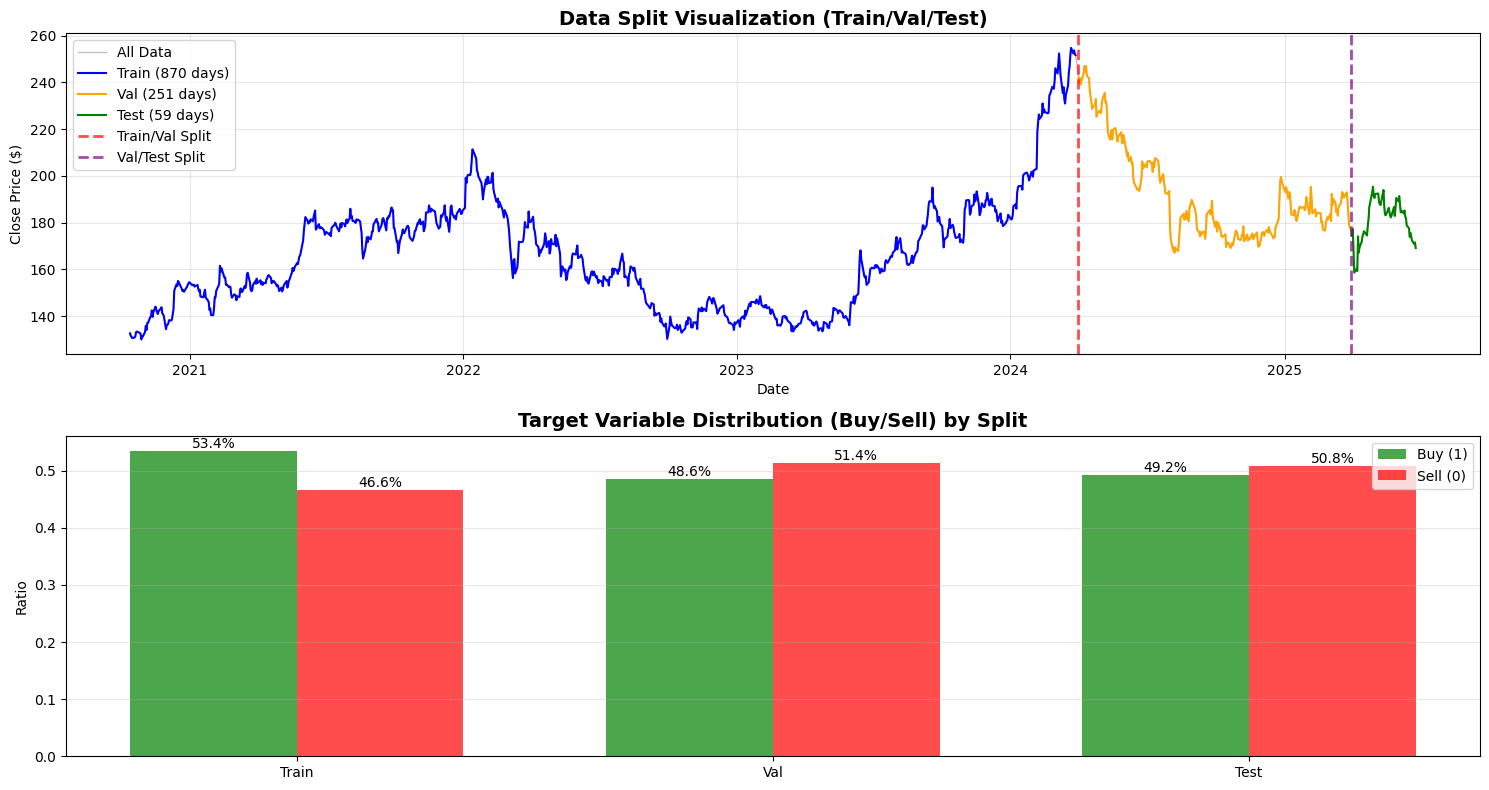


Dataset Split Summary:
  Train:  870 days ( 73.7%) - Buy: 53.4%, Sell: 46.6%
  Val:    251 days ( 21.3%) - Buy: 48.6%, Sell: 51.4%
  Test:    59 days (  5.0%) - Buy: 49.2%, Sell: 50.8%

Window Dataset Shapes:
  X_train_reg: (840, 30, 20), X_val_reg: (221, 30, 20), X_test_reg: (29, 30, 20)


In [9]:
# === データ分割の可視化 ===
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# 1. 全期間の終値とデータ分割
ax1 = axes[0]
ax1.plot(df.index, df['close'], linewidth=1, color='gray', alpha=0.5, label='All Data')
ax1.plot(train.index, train['close'], linewidth=1.5, color='blue', label=f'Train ({len(train)} days)')
ax1.plot(val.index, val['close'], linewidth=1.5, color='orange', label=f'Val ({len(val)} days)')
ax1.plot(test.index, test['close'], linewidth=1.5, color='green', label=f'Test ({len(test)} days)')

# 分割境界線
ax1.axvline(pd.to_datetime(SPLIT_TRAIN_END), color='red', linestyle='--', linewidth=2, alpha=0.7, label='Train/Val Split')
ax1.axvline(pd.to_datetime(SPLIT_VAL_END), color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Val/Test Split')

ax1.set_title('Data Split Visualization (Train/Val/Test)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price ($)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# 2. ターゲット変数（Buy/Sellラベル）の分布
ax2 = axes[1]
train_buy_ratio = train['target_buy'].mean()
val_buy_ratio = val['target_buy'].mean()
test_buy_ratio = test['target_buy'].mean()

splits = ['Train', 'Val', 'Test']
buy_ratios = [train_buy_ratio, val_buy_ratio, test_buy_ratio]
sell_ratios = [1-train_buy_ratio, 1-val_buy_ratio, 1-test_buy_ratio]

x = np.arange(len(splits))
width = 0.35

bars1 = ax2.bar(x - width/2, buy_ratios, width, label='Buy (1)', color='green', alpha=0.7)
bars2 = ax2.bar(x + width/2, sell_ratios, width, label='Sell (0)', color='red', alpha=0.7)

# バーの上に割合を表示
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center', va='bottom', fontsize=10)

ax2.set_ylabel('Ratio')
ax2.set_title('Target Variable Distribution (Buy/Sell) by Split', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(splits)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nDataset Split Summary:")
print(f"  Train: {len(train):4d} days ({len(train)/len(df)*100:5.1f}%) - Buy: {train_buy_ratio:.1%}, Sell: {1-train_buy_ratio:.1%}")
print(f"  Val:   {len(val):4d} days ({len(val)/len(df)*100:5.1f}%) - Buy: {val_buy_ratio:.1%}, Sell: {1-val_buy_ratio:.1%}")
print(f"  Test:  {len(test):4d} days ({len(test)/len(df)*100:5.1f}%) - Buy: {test_buy_ratio:.1%}, Sell: {1-test_buy_ratio:.1%}")
print(f"\nWindow Dataset Shapes:")
print(f"  X_train_reg: {X_train_reg.shape}, X_val_reg: {X_val_reg.shape}, X_test_reg: {X_test_reg.shape}")

In [10]:
# === ベースライン：線形回帰（回帰） ===
# ウィンドウを平均で潰して単純特徴に落とす簡易ベースライン
def collapse_window_mean(X):
    # (N, window, F) -> (N, F) by mean
    return X.mean(axis=1)

Xtr_bl = collapse_window_mean(X_train_reg)
Xv_bl  = collapse_window_mean(X_val_reg)
Xte_bl = collapse_window_mean(X_test_reg)

linr = LinearRegression()
linr.fit(Xtr_bl, y_train_reg_scaled)

# 予測（スケーリング済み）
pred_tr_bl_scaled = linr.predict(Xtr_bl)
pred_v_bl_scaled  = linr.predict(Xv_bl)
pred_te_bl_scaled = linr.predict(Xte_bl)

# 逆スケーリングして元のスケールに戻す
pred_tr_bl = scaler_y.inverse_transform(pred_tr_bl_scaled.reshape(-1, 1)).ravel()
pred_v_bl  = scaler_y.inverse_transform(pred_v_bl_scaled.reshape(-1, 1)).ravel()
pred_te_bl = scaler_y.inverse_transform(pred_te_bl_scaled.reshape(-1, 1)).ravel()

def rmse(y, p): return math.sqrt(mean_squared_error(y, p))

print('Baseline Linear Regression')
print('  Train RMSE:', rmse(y_train_reg, pred_tr_bl))
print('  Val   RMSE:', rmse(y_val_reg,   pred_v_bl))
print('  Test  RMSE:', rmse(y_test_reg,  pred_te_bl))

print('  Test R2  :', r2_score(y_test_reg, pred_te_bl))

Baseline Linear Regression
  Train RMSE: 4.817299382024113
  Val   RMSE: 10.435972692566642
  Test  RMSE: 8.794026631901053
  Test R2  : -1.023922009535799


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,849 (214.25 KB)

 Trainable params: 54,849 (214.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2724 - val_loss: 0.3022 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0851 - val_loss: 0.2246 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0541 - val_loss: 0.1910 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0426 - val_loss: 0.1994 - learning_rate: 0.0010
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0335 - val_loss: 0.1787 - learning_rate: 0.0010
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0314 - val_loss: 0.1615 - learning_rate: 0.0010
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0303 - val_loss: 0.1475 - learning_rate: 0.0010
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0284 - val_loss: 0.1469 - learning_rate: 0.0010
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0267 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 10/50
14/14 ━

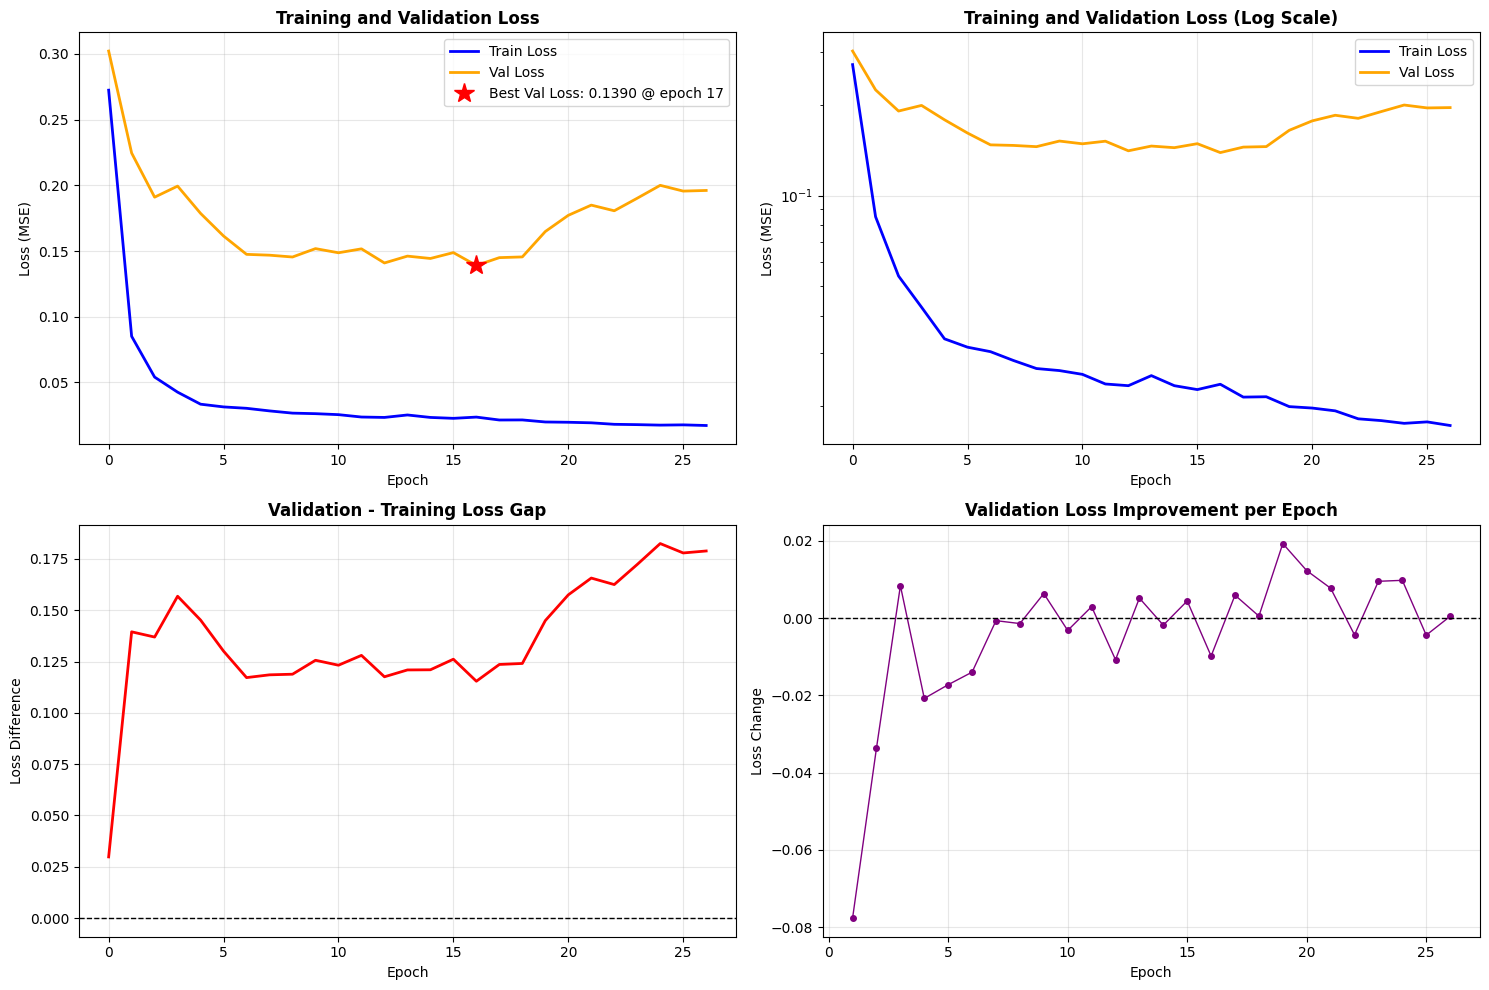


Training visualization complete!


In [11]:
# === LSTM（回帰：翌日終値） ===
tf.keras.backend.clear_session()

model_reg = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_reg.shape[1], X_train_reg.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(1, activation='linear')
])
model_reg.compile(optimizer='adam', loss='mse')

print("Model Architecture:")
model_reg.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=5, factor=0.5, monitor='val_loss', verbose=1),
    ModelCheckpoint('best_regression.keras', monitor='val_loss', save_best_only=True, verbose=0)
]

hist = model_reg.fit(
    X_train_reg, y_train_reg_scaled,
    validation_data=(X_val_reg, y_val_reg_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# 推論（スケーリング済み）
pred_tr_scaled = model_reg.predict(X_train_reg, verbose=0).ravel()
pred_v_scaled  = model_reg.predict(X_val_reg, verbose=0).ravel()
pred_te_scaled = model_reg.predict(X_test_reg, verbose=0).ravel()

# 逆スケーリングして元のスケールに戻す
pred_tr = scaler_y.inverse_transform(pred_tr_scaled.reshape(-1, 1)).ravel()
pred_v  = scaler_y.inverse_transform(pred_v_scaled.reshape(-1, 1)).ravel()
pred_te = scaler_y.inverse_transform(pred_te_scaled.reshape(-1, 1)).ravel()

print('\n' + '='*60)
print('LSTM Regression Results')
print('='*60)
print(f'  Train RMSE: {rmse(y_train_reg, pred_tr):.4f}')
print(f'  Val   RMSE: {rmse(y_val_reg, pred_v):.4f}')
print(f'  Test  RMSE: {rmse(y_test_reg, pred_te):.4f}')
print(f'  Test R2:    {r2_score(y_test_reg, pred_te):.4f}')
print('='*60)

# === 学習曲線の詳細可視化 ===
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Loss曲線（通常スケール）
ax1 = axes[0, 0]
ax1.plot(hist.history['loss'], label='Train Loss', linewidth=2, color='blue')
ax1.plot(hist.history['val_loss'], label='Val Loss', linewidth=2, color='orange')
ax1.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 最小値にマーカー
min_val_loss_epoch = np.argmin(hist.history['val_loss'])
min_val_loss = hist.history['val_loss'][min_val_loss_epoch]
ax1.plot(min_val_loss_epoch, min_val_loss, 'r*', markersize=15, 
         label=f'Best Val Loss: {min_val_loss:.4f} @ epoch {min_val_loss_epoch+1}')
ax1.legend()

# 2. Loss曲線（対数スケール）
ax2 = axes[0, 1]
ax2.plot(hist.history['loss'], label='Train Loss', linewidth=2, color='blue')
ax2.plot(hist.history['val_loss'], label='Val Loss', linewidth=2, color='orange')
ax2.set_title('Training and Validation Loss (Log Scale)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss (MSE)')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Train/Valの差分
ax3 = axes[1, 0]
loss_diff = np.array(hist.history['val_loss']) - np.array(hist.history['loss'])
ax3.plot(loss_diff, linewidth=2, color='red')
ax3.axhline(0, linestyle='--', color='black', linewidth=1)
ax3.set_title('Validation - Training Loss Gap', fontsize=12, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss Difference')
ax3.grid(True, alpha=0.3)

# 4. エポックごとの改善率
ax4 = axes[1, 1]
val_loss_improvement = np.diff(hist.history['val_loss'])
ax4.plot(range(1, len(val_loss_improvement)+1), val_loss_improvement, 
         marker='o', linewidth=1, markersize=4, color='purple')
ax4.axhline(0, linestyle='--', color='black', linewidth=1)
ax4.set_title('Validation Loss Improvement per Epoch', fontsize=12, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss Change')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining visualization complete!")

Training Improved LSTM Model
Improved Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       152,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 30, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,377 (927.25 KB)

 Trainable params: 237,377 (927.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.1833 - val_loss: 0.2023
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1992 - val_loss: 0.1965
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0998 - val_loss: 0.1658
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0705 - val_loss: 0.1946
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0515 - val_loss: 0.1407
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0530 - val_loss: 0.1364
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0396 - val_loss: 0.1478
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0375 - val_loss: 0.1412
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0496 - val_loss: 0.1240
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0353 - val_loss: 0.1234
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0354 - val_loss: 0.1317
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0

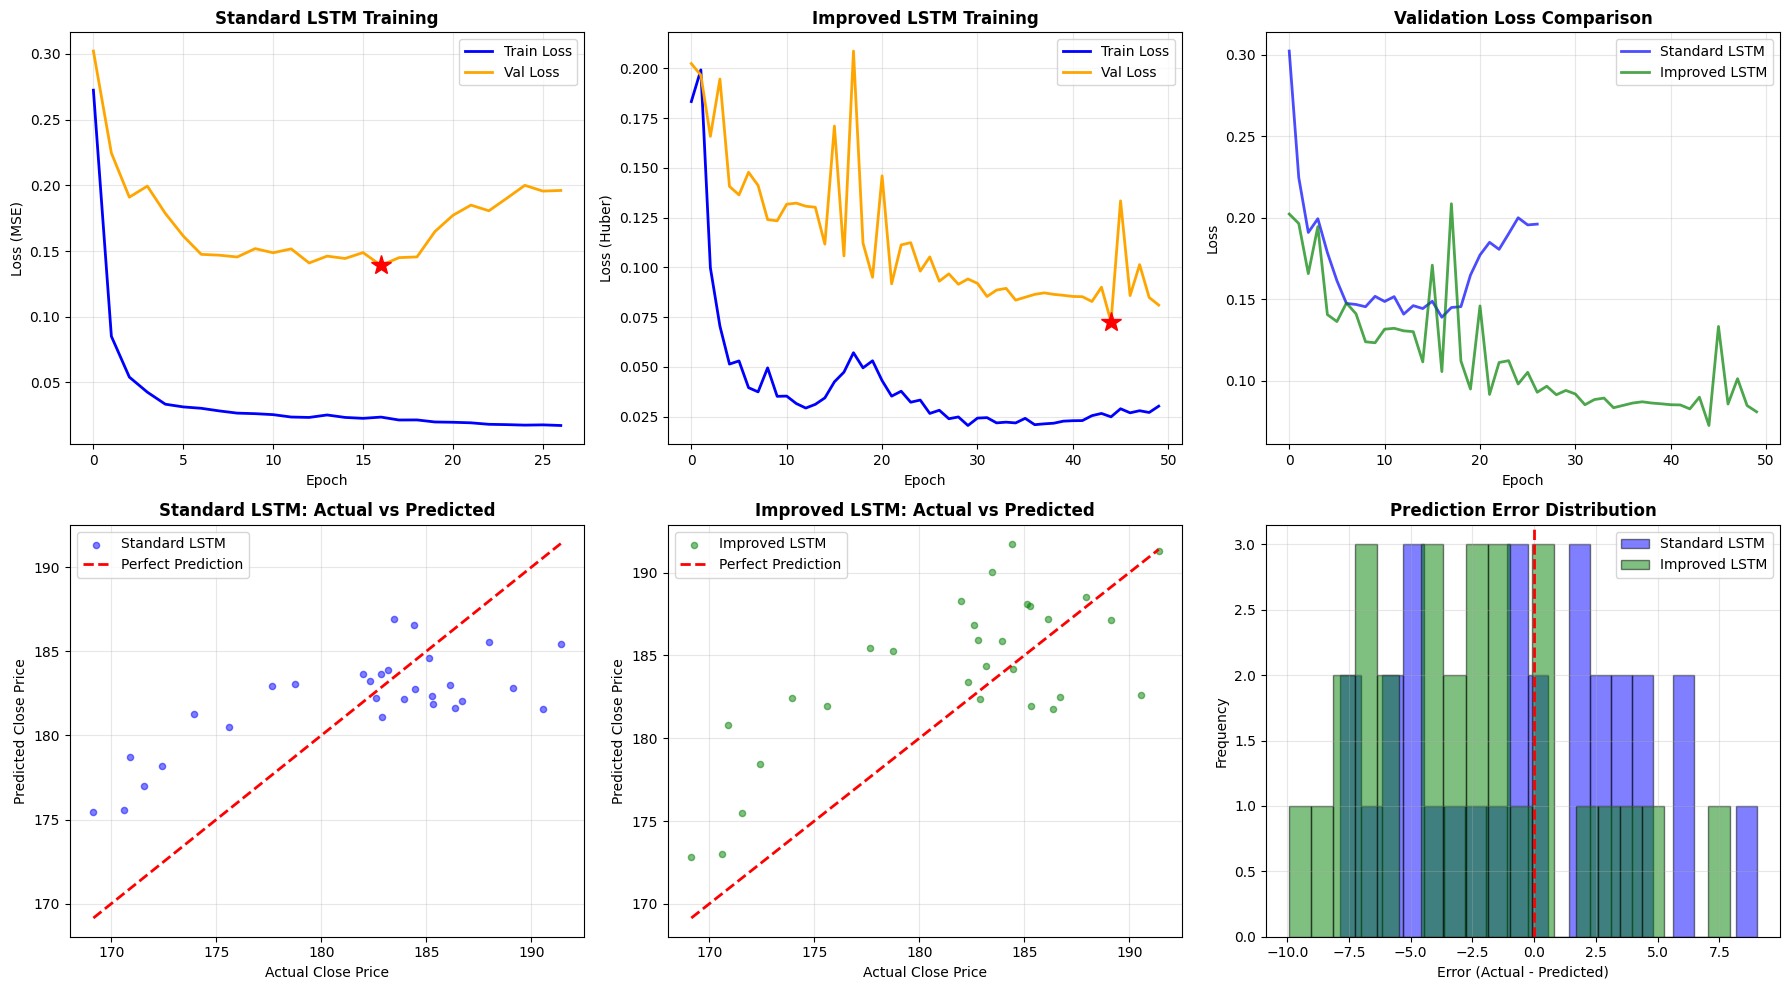


Improved model training and comparison complete!


In [12]:
# === 改良版 LSTM（回帰：翌日終値） ===
print('='*70)
print('Training Improved LSTM Model')
print('='*70)

tf.keras.backend.clear_session()

from tensorflow.keras.layers import Bidirectional, LayerNormalization
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.losses import Huber

# 1) 学習率スケジュール + AdamW + クリッピング
initial_lr = 1e-3
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=initial_lr,
    first_decay_steps=200,   # データ量/バッチに応じて調整可
    t_mul=2.0,
    m_mul=0.8,
    alpha=1e-4               # 最小学習率
)
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4,
    clipnorm=1.0             # 勾配クリッピング
)

# 2) モデル（BiLSTM + 正則化）
model_reg_improved = Sequential([
    Bidirectional(LSTM(128, return_sequences=True),
                  input_shape=(X_train_reg.shape[1], X_train_reg.shape[2])),
    Dropout(0.30),
    LayerNormalization(),

    LSTM(64, return_sequences=False),
    Dropout(0.25),

    Dense(32, activation='swish'),
    Dropout(0.10),

    Dense(1, activation='linear')
])

# 3) Huber損失（外れ値に強い）
model_reg_improved.compile(optimizer=optimizer, loss=Huber(delta=1.0))

print("Improved Model Architecture:")
model_reg_improved.summary()

callbacks_improved = [
    EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor='val_loss',
        mode='min'
    ),
    ModelCheckpoint(
        'best_regression_improved.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )
]

hist_improved = model_reg_improved.fit(
    X_train_reg, y_train_reg_scaled,
    validation_data=(X_val_reg, y_val_reg_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_improved,
    verbose=1,
    shuffle=False  # 時系列はFalseが基本
)

# 推論（スケーリング済み）
pred_tr_improved_scaled = model_reg_improved.predict(X_train_reg, verbose=0).ravel()
pred_v_improved_scaled  = model_reg_improved.predict(X_val_reg, verbose=0).ravel()
pred_te_improved_scaled = model_reg_improved.predict(X_test_reg, verbose=0).ravel()

# 逆スケーリングして元のスケールに戻す
pred_tr_improved = scaler_y.inverse_transform(pred_tr_improved_scaled.reshape(-1, 1)).ravel()
pred_v_improved  = scaler_y.inverse_transform(pred_v_improved_scaled.reshape(-1, 1)).ravel()
pred_te_improved = scaler_y.inverse_transform(pred_te_improved_scaled.reshape(-1, 1)).ravel()

print('\n' + '='*60)
print('Improved LSTM Regression Results')
print('='*60)
print(f'  Train RMSE: {rmse(y_train_reg, pred_tr_improved):.4f}')
print(f'  Val   RMSE: {rmse(y_val_reg, pred_v_improved):.4f}')
print(f'  Test  RMSE: {rmse(y_test_reg, pred_te_improved):.4f}')
print(f'  Test R2:    {r2_score(y_test_reg, pred_te_improved):.4f}')
print('='*60)

# === 比較：ベースライン vs 標準LSTM vs 改良LSTM ===
print('\n' + '='*60)
print('Model Comparison Summary')
print('='*60)
print(f'{"Model":<25} {"Test RMSE":<12} {"Test R²":<12}')
print('-'*60)
print(f'{"Baseline (Linear Reg)":<25} {rmse(y_test_reg, pred_te_bl):>11.4f} {r2_score(y_test_reg, pred_te_bl):>11.4f}')
print(f'{"Standard LSTM":<25} {rmse(y_test_reg, pred_te):>11.4f} {r2_score(y_test_reg, pred_te):>11.4f}')
print(f'{"Improved LSTM":<25} {rmse(y_test_reg, pred_te_improved):>11.4f} {r2_score(y_test_reg, pred_te_improved):>11.4f}')
print('='*60)

# 改善率の計算
baseline_rmse = rmse(y_test_reg, pred_te_bl)
standard_rmse = rmse(y_test_reg, pred_te)
improved_rmse = rmse(y_test_reg, pred_te_improved)

improvement_vs_baseline = ((baseline_rmse - improved_rmse) / baseline_rmse) * 100
improvement_vs_standard = ((standard_rmse - improved_rmse) / standard_rmse) * 100

print(f'\nImprovement:')
print(f'  vs Baseline: {improvement_vs_baseline:+.2f}%')
print(f'  vs Standard LSTM: {improvement_vs_standard:+.2f}%')

# === 学習曲線の比較可視化 ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 標準LSTMの学習曲線
ax1 = axes[0, 0]
ax1.plot(hist.history['loss'], label='Train Loss', linewidth=2, color='blue')
ax1.plot(hist.history['val_loss'], label='Val Loss', linewidth=2, color='orange')
min_val_loss_epoch = np.argmin(hist.history['val_loss'])
min_val_loss = hist.history['val_loss'][min_val_loss_epoch]
ax1.plot(min_val_loss_epoch, min_val_loss, 'r*', markersize=15)
ax1.set_title('Standard LSTM Training', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 改良LSTMの学習曲線
ax2 = axes[0, 1]
ax2.plot(hist_improved.history['loss'], label='Train Loss', linewidth=2, color='blue')
ax2.plot(hist_improved.history['val_loss'], label='Val Loss', linewidth=2, color='orange')
min_val_loss_epoch_imp = np.argmin(hist_improved.history['val_loss'])
min_val_loss_imp = hist_improved.history['val_loss'][min_val_loss_epoch_imp]
ax2.plot(min_val_loss_epoch_imp, min_val_loss_imp, 'r*', markersize=15)
ax2.set_title('Improved LSTM Training', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss (Huber)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 両方の学習曲線を重ねて比較
ax3 = axes[0, 2]
ax3.plot(hist.history['val_loss'], label='Standard LSTM', linewidth=2, color='blue', alpha=0.7)
ax3.plot(hist_improved.history['val_loss'], label='Improved LSTM', linewidth=2, color='green', alpha=0.7)
ax3.set_title('Validation Loss Comparison', fontsize=12, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 予測値 vs 実際値（標準LSTM）
ax4 = axes[1, 0]
ax4.scatter(y_test_reg, pred_te, alpha=0.5, s=20, color='blue', label='Standard LSTM')
ax4.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax4.set_title('Standard LSTM: Actual vs Predicted', fontsize=12, fontweight='bold')
ax4.set_xlabel('Actual Close Price')
ax4.set_ylabel('Predicted Close Price')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. 予測値 vs 実際値（改良LSTM）
ax5 = axes[1, 1]
ax5.scatter(y_test_reg, pred_te_improved, alpha=0.5, s=20, color='green', label='Improved LSTM')
ax5.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax5.set_title('Improved LSTM: Actual vs Predicted', fontsize=12, fontweight='bold')
ax5.set_xlabel('Actual Close Price')
ax5.set_ylabel('Predicted Close Price')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. 予測誤差の分布比較
ax6 = axes[1, 2]
errors_standard = y_test_reg - pred_te
errors_improved = y_test_reg - pred_te_improved
ax6.hist(errors_standard, bins=20, alpha=0.5, label='Standard LSTM', color='blue', edgecolor='black')
ax6.hist(errors_improved, bins=20, alpha=0.5, label='Improved LSTM', color='green', edgecolor='black')
ax6.axvline(0, color='red', linestyle='--', linewidth=2)
ax6.set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
ax6.set_xlabel('Error (Actual - Predicted)')
ax6.set_ylabel('Frequency')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nImproved model training and comparison complete!")

In [13]:
# === 改良版モデルでの分類・バックテスト ===
print('\n' + '='*70)
print('Improved Model: Buy/Sell Classification & Backtest')
print('='*70)

# 必要な変数を確認（分類セルで定義されているはず）
if 'close_test_tail' not in dir():
    print('⚠️  Warning: close_test_tail not found. Please run the classification cell first.')
    print('   Skipping improved model evaluation.')
else:
    # Buy/Sell判定（改良版モデル）
    buy_pred_te_improved = (pred_te_improved > close_test_tail).astype(int)

    # 分類性能
    metrics_te_improved = cls_metrics(y_test_cls, buy_pred_te_improved)

    print('\n分類性能比較:')
    print(f'{"Model":<20} {"Accuracy":<12} {"Precision":<12} {"Recall":<12} {"F1":<12}')
    print('-'*70)
    print(f'{"Standard LSTM":<20} {metrics_te["acc"]:>11.4f} {metrics_te["prec"]:>11.4f} {metrics_te["rec"]:>11.4f} {metrics_te["f1"]:>11.4f}')
    print(f'{"Improved LSTM":<20} {metrics_te_improved["acc"]:>11.4f} {metrics_te_improved["prec"]:>11.4f} {metrics_te_improved["rec"]:>11.4f} {metrics_te_improved["f1"]:>11.4f}')

    # バックテスト（改良版）
    ret_improved = np.zeros_like(buy_pred_te_improved, dtype=float)
    ret_improved[buy_pred_te_improved == 1] = price_diff[buy_pred_te_improved == 1]
    cum_ret_improved = (1 + ret_improved).cumprod() - 1

    print('\nバックテスト比較:')
    print(f'{"Model":<20} {"Final Return":<15} {"# Trades":<12} {"Win Rate":<12}')
    print('-'*70)

    # 標準LSTMの統計
    n_trades_standard = buy_pred_te.sum()
    if n_trades_standard > 0:
        trade_returns_standard = ret[buy_pred_te == 1]
        wins_standard = (trade_returns_standard > 0).sum()
        win_rate_standard = wins_standard / n_trades_standard
    else:
        win_rate_standard = 0

    # 改良LSTMの統計
    n_trades_improved = buy_pred_te_improved.sum()
    if n_trades_improved > 0:
        trade_returns_improved = ret_improved[buy_pred_te_improved == 1]
        wins_improved = (trade_returns_improved > 0).sum()
        win_rate_improved = wins_improved / n_trades_improved
    else:
        win_rate_improved = 0

    print(f'{"Standard LSTM":<20} {cum_ret[-1]:>14.2%} {n_trades_standard:>11} {win_rate_standard:>11.2%}')
    print(f'{"Improved LSTM":<20} {cum_ret_improved[-1]:>14.2%} {n_trades_improved:>11} {win_rate_improved:>11.2%}')
    print(f'{"Buy & Hold":<20} {buy_hold_ret_aligned[-1]:>14.2%} {"-":>11} {"-":>11}')

    # === 可視化：バックテスト比較 ===
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # 1. 累積リターンの比較
    ax1 = axes[0, 0]
    ax1.plot(cum_ret, label='Standard LSTM', linewidth=2, color='blue')
    ax1.plot(cum_ret_improved, label='Improved LSTM', linewidth=2, color='green')
    ax1.plot(buy_hold_ret_aligned, label='Buy & Hold', linewidth=2, color='gray', linestyle='--')
    ax1.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
    ax1.set_title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Trading Days')
    ax1.set_ylabel('Cumulative Return')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 最終リターンを表示
    final_returns_text = f'Standard: {cum_ret[-1]:.2%}\nImproved: {cum_ret_improved[-1]:.2%}\nB&H: {buy_hold_ret_aligned[-1]:.2%}'
    ax1.text(0.02, 0.98, final_returns_text,
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 2. Buy信号の割合比較
    ax2 = axes[0, 1]
    models = ['Actual', 'Standard\nLSTM', 'Improved\nLSTM']
    buy_ratios = [
        y_test_cls.mean(),
        buy_pred_te.mean(),
        buy_pred_te_improved.mean()
    ]
    colors = ['gray', 'blue', 'green']
    bars = ax2.bar(models, buy_ratios, color=colors, alpha=0.7)
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center', va='bottom', fontsize=10)
    ax2.set_ylabel('Buy Signal Ratio')
    ax2.set_title('Buy Signal Distribution', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1.0)
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Confusion Matrix比較（標準LSTM）
    ax3 = axes[1, 0]
    cm_standard = confusion_matrix(y_test_cls, buy_pred_te)
    from sklearn.metrics import ConfusionMatrixDisplay
    disp_standard = ConfusionMatrixDisplay(confusion_matrix=cm_standard, display_labels=['Sell', 'Buy'])
    disp_standard.plot(ax=ax3, cmap='Blues', values_format='d')
    ax3.set_title('Standard LSTM: Confusion Matrix', fontsize=12, fontweight='bold')

    # 4. Confusion Matrix比較（改良LSTM）
    ax4 = axes[1, 1]
    cm_improved = confusion_matrix(y_test_cls, buy_pred_te_improved)
    disp_improved = ConfusionMatrixDisplay(confusion_matrix=cm_improved, display_labels=['Sell', 'Buy'])
    disp_improved.plot(ax=ax4, cmap='Greens', values_format='d')
    ax4.set_title('Improved LSTM: Confusion Matrix', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # === 詳細な統計比較 ===
    print('\n' + '='*70)
    print('Detailed Statistics Comparison')
    print('='*70)

    print('\n【予測バイアス】')
    print(f'  Standard LSTM: 平均予測差 = {(pred_te - close_test_tail).mean():+.4f}')
    print(f'  Improved LSTM: 平均予測差 = {(pred_te_improved - close_test_tail).mean():+.4f}')
    print(f'  (正の値 = 楽観的, 負の値 = 悲観的)')

    print('\n【Buy信号の精度】')
    print(f'  実際のBuy割合: {y_test_cls.mean():.1%}')
    print(f'  Standard予測: {buy_pred_te.mean():.1%} (差分: {(buy_pred_te.mean() - y_test_cls.mean())*100:+.1f}%)')
    print(f'  Improved予測: {buy_pred_te_improved.mean():.1%} (差分: {(buy_pred_te_improved.mean() - y_test_cls.mean())*100:+.1f}%)')

    print('\n【トレード統計】')
    if n_trades_standard > 0:
        print(f'  Standard LSTM:')
        print(f'    トレード数: {n_trades_standard}')
        print(f'    勝率: {win_rate_standard:.2%}')
        print(f'    平均リターン: {trade_returns_standard.mean():.4f}')
        
    if n_trades_improved > 0:
        print(f'  Improved LSTM:')
        print(f'    トレード数: {n_trades_improved}')
        print(f'    勝率: {win_rate_improved:.2%}')
        print(f'    平均リターン: {trade_returns_improved.mean():.4f}')

    print('='*70)
    print('\n✓ Improved model evaluation complete!')


Improved Model: Buy/Sell Classification & Backtest
⚠️  Warning: close_test_tail not found. Please run the classification cell first.
   Skipping improved model evaluation.


Classification Metrics (Buy=1 / Sell=0)
Train: Acc=0.5917, Prec=0.6218, Rec=0.5982, F1=0.6098
Val:   Acc=0.5475, Prec=0.5312, Rec=0.6296, F1=0.5763
Test:  Acc=0.5172, Prec=0.3333, Rec=0.2727, F1=0.3000

Confusion Matrix (Test)
[[12  6]
 [ 8  3]]

Classification Report (Test)
              precision    recall  f1-score   support

    Sell (0)       0.60      0.67      0.63        18
     Buy (1)       0.33      0.27      0.30        11

    accuracy                           0.52        29
   macro avg       0.47      0.47      0.47        29
weighted avg       0.50      0.52      0.51        29



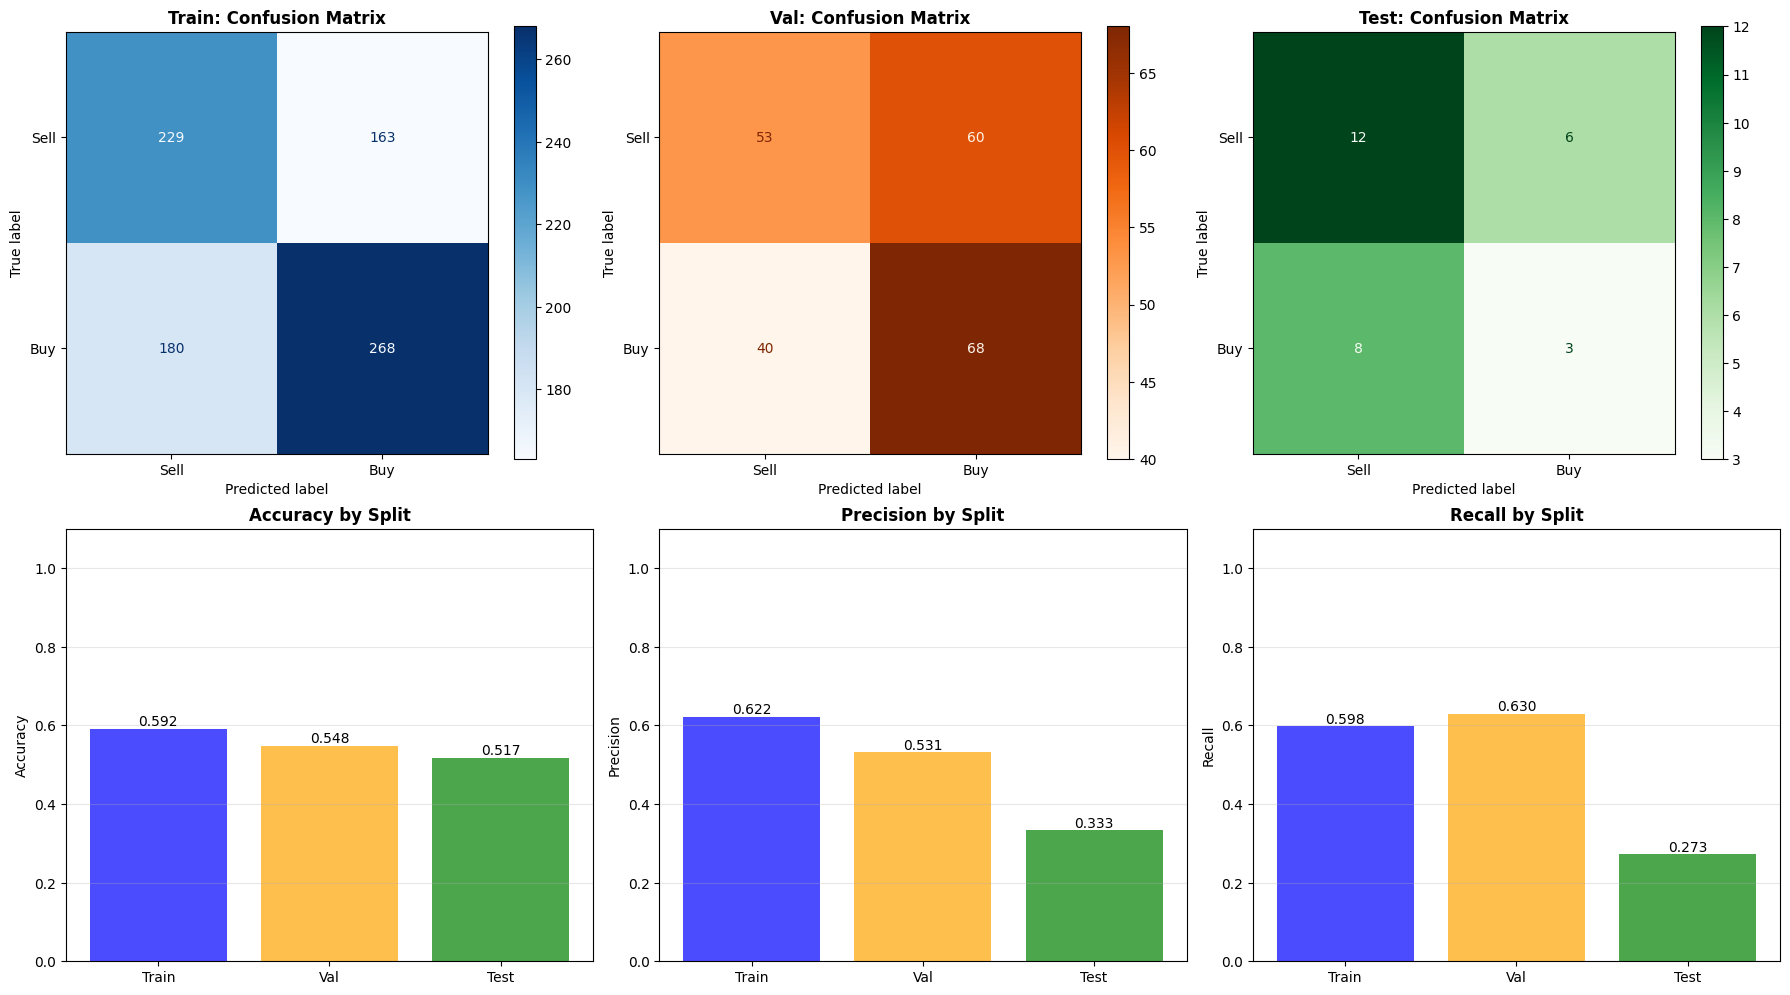

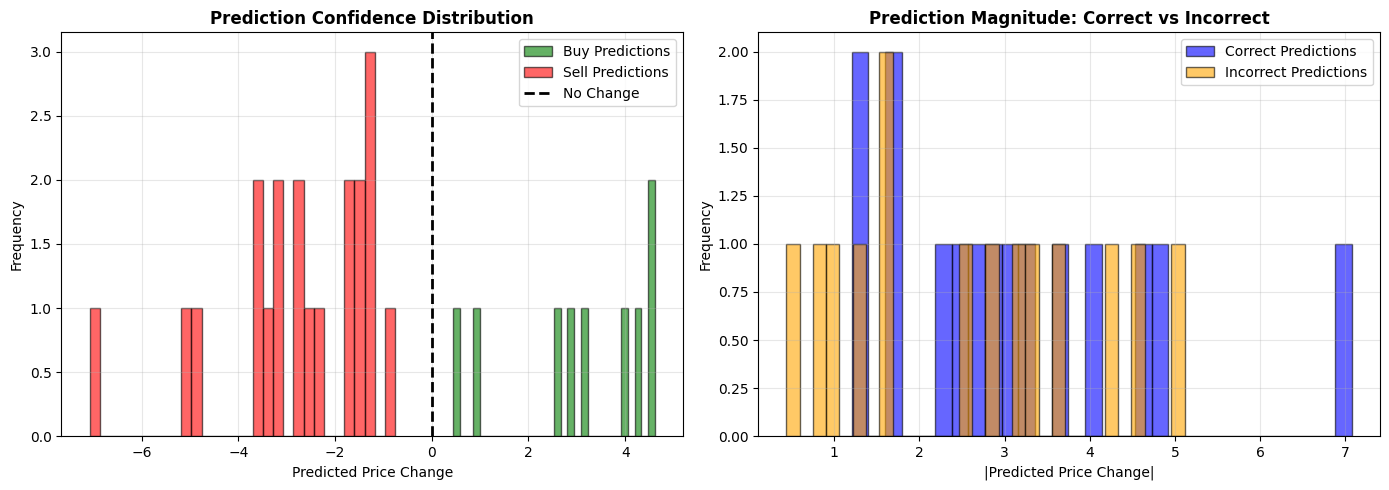


Classification visualization complete!


In [14]:
# === 分類：予測終値に基づく Buy(1)/Sell(0) 判定 ===
# 判定ロジック： pred_close_{t+1} > actual_close_{t} ? 1 : 0
# 時系列整合のため、各セットの基準 day_t の close 実値を準備する

def get_last_close_vector(df_part, window):
    # 各サンプルの "直近日の実Close" を取り出す (ラベル生成用)
    vals = df_part['close'].values  # *スケール前* が本来望ましいが、ここは y と比較するだけなので OK
    # ウィンドウで切った最後の行の index を対応づけ
    out = []
    for i in range(len(df_part) - window):
        out.append(vals[i + window - 1])
    return np.array(out)

close_train_tail = get_last_close_vector(train, WINDOW_SIZE)
close_val_tail   = get_last_close_vector(val,   WINDOW_SIZE)
close_test_tail  = get_last_close_vector(test,  WINDOW_SIZE)

buy_pred_tr = (pred_tr > close_train_tail).astype(int)
buy_pred_v  = (pred_v  > close_val_tail).astype(int)
buy_pred_te = (pred_te > close_test_tail).astype(int)

print('='*60)
print('Classification Metrics (Buy=1 / Sell=0)')
print('='*60)

def cls_metrics(y_true, y_pred):
    return {
        'acc': accuracy_score(y_true, y_pred),
        'prec': precision_score(y_true, y_pred, zero_division=0),
        'rec': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
    }

metrics_tr = cls_metrics(y_train_cls, buy_pred_tr)
metrics_v = cls_metrics(y_val_cls, buy_pred_v)
metrics_te = cls_metrics(y_test_cls, buy_pred_te)

print(f'Train: Acc={metrics_tr["acc"]:.4f}, Prec={metrics_tr["prec"]:.4f}, Rec={metrics_tr["rec"]:.4f}, F1={metrics_tr["f1"]:.4f}')
print(f'Val:   Acc={metrics_v["acc"]:.4f}, Prec={metrics_v["prec"]:.4f}, Rec={metrics_v["rec"]:.4f}, F1={metrics_v["f1"]:.4f}')
print(f'Test:  Acc={metrics_te["acc"]:.4f}, Prec={metrics_te["prec"]:.4f}, Rec={metrics_te["rec"]:.4f}, F1={metrics_te["f1"]:.4f}')
print('='*60)

# Confusion Matrix (Test)
cm = confusion_matrix(y_test_cls, buy_pred_te)
print('\nConfusion Matrix (Test)')
print(cm)
print('\nClassification Report (Test)')
print(classification_report(y_test_cls, buy_pred_te, zero_division=0, target_names=['Sell (0)', 'Buy (1)']))

# === 分類性能の詳細可視化 ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Confusion Matrix (Train)
from sklearn.metrics import ConfusionMatrixDisplay
cm_train = confusion_matrix(y_train_cls, buy_pred_tr)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Sell', 'Buy'])
disp_train.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title('Train: Confusion Matrix', fontsize=12, fontweight='bold')

# 2. Confusion Matrix (Val)
cm_val = confusion_matrix(y_val_cls, buy_pred_v)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Sell', 'Buy'])
disp_val.plot(ax=axes[0, 1], cmap='Oranges', values_format='d')
axes[0, 1].set_title('Val: Confusion Matrix', fontsize=12, fontweight='bold')

# 3. Confusion Matrix (Test)
cm_test = confusion_matrix(y_test_cls, buy_pred_te)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Sell', 'Buy'])
disp_test.plot(ax=axes[0, 2], cmap='Greens', values_format='d')
axes[0, 2].set_title('Test: Confusion Matrix', fontsize=12, fontweight='bold')

# 4. メトリクス比較（Train/Val/Test）
splits = ['Train', 'Val', 'Test']
metrics_list = [metrics_tr, metrics_v, metrics_te]

metric_names = ['acc', 'prec', 'rec', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric_name, metric_label) in enumerate(zip(metric_names, metric_labels)):
    ax = axes[1, idx] if idx < 3 else None
    if ax is None:
        continue
    
    values = [m[metric_name] for m in metrics_list]
    bars = ax.bar(splits, values, color=['blue', 'orange', 'green'], alpha=0.7)
    
    # バーの上に値を表示
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel(metric_label)
    ax.set_title(f'{metric_label} by Split', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

# 5. 予測信頼度分布（Test: 予測終値 - 現在終値の差分）
if len(axes[1]) > 3:
    axes[1, 3].remove()

plt.tight_layout()
plt.show()

# === 予測の信頼度分析 ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test期間の予測差分（予測終値 - 現在終値）
pred_diff = pred_te - close_test_tail

# 1. Buy/Sell別の予測差分分布
ax1 = axes[0]
buy_mask = buy_pred_te == 1
sell_mask = buy_pred_te == 0

ax1.hist(pred_diff[buy_mask], bins=30, alpha=0.6, label='Buy Predictions', color='green', edgecolor='black')
ax1.hist(pred_diff[sell_mask], bins=30, alpha=0.6, label='Sell Predictions', color='red', edgecolor='black')
ax1.axvline(0, color='black', linestyle='--', linewidth=2, label='No Change')
ax1.set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Price Change')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 正解/不正解別の予測差分分布
ax2 = axes[1]
correct_mask = (buy_pred_te == y_test_cls).astype(bool)
incorrect_mask = ~correct_mask

ax2.hist(np.abs(pred_diff[correct_mask]), bins=30, alpha=0.6, label='Correct Predictions', 
         color='blue', edgecolor='black')
ax2.hist(np.abs(pred_diff[incorrect_mask]), bins=30, alpha=0.6, label='Incorrect Predictions', 
         color='orange', edgecolor='black')
ax2.set_title('Prediction Magnitude: Correct vs Incorrect', fontsize=12, fontweight='bold')
ax2.set_xlabel('|Predicted Price Change|')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nClassification visualization complete!")

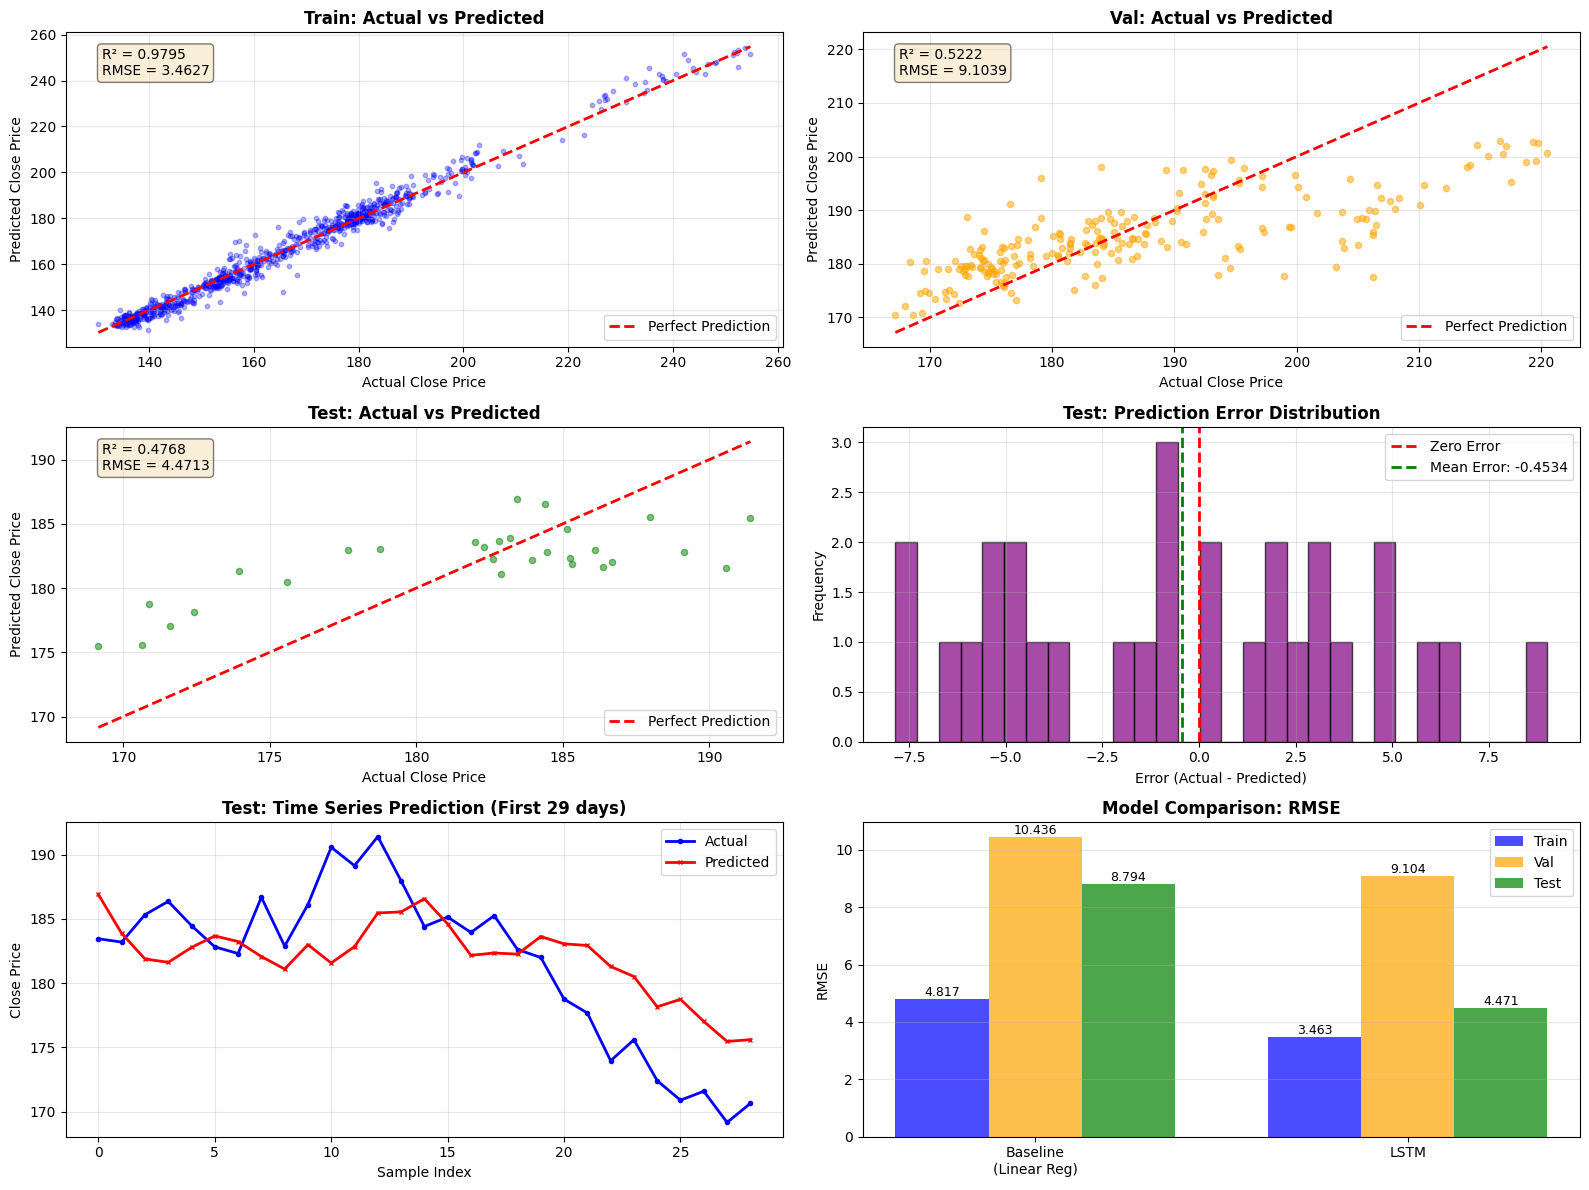


Prediction visualization complete!


In [15]:
# === 予測結果の詳細可視化 ===
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Train: 実際の値 vs 予測値（散布図）
ax1 = axes[0, 0]
ax1.scatter(y_train_reg, pred_tr, alpha=0.3, s=10, color='blue')
ax1.plot([y_train_reg.min(), y_train_reg.max()], 
         [y_train_reg.min(), y_train_reg.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax1.set_title('Train: Actual vs Predicted', fontsize=12, fontweight='bold')
ax1.set_xlabel('Actual Close Price')
ax1.set_ylabel('Predicted Close Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# R2スコアを表示
r2_train = r2_score(y_train_reg, pred_tr)
ax1.text(0.05, 0.95, f'R² = {r2_train:.4f}\nRMSE = {rmse(y_train_reg, pred_tr):.4f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Val: 実際の値 vs 予測値
ax2 = axes[0, 1]
ax2.scatter(y_val_reg, pred_v, alpha=0.5, s=20, color='orange')
ax2.plot([y_val_reg.min(), y_val_reg.max()], 
         [y_val_reg.min(), y_val_reg.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax2.set_title('Val: Actual vs Predicted', fontsize=12, fontweight='bold')
ax2.set_xlabel('Actual Close Price')
ax2.set_ylabel('Predicted Close Price')
ax2.legend()
ax2.grid(True, alpha=0.3)

r2_val = r2_score(y_val_reg, pred_v)
ax2.text(0.05, 0.95, f'R² = {r2_val:.4f}\nRMSE = {rmse(y_val_reg, pred_v):.4f}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Test: 実際の値 vs 予測値
ax3 = axes[1, 0]
ax3.scatter(y_test_reg, pred_te, alpha=0.5, s=20, color='green')
ax3.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax3.set_title('Test: Actual vs Predicted', fontsize=12, fontweight='bold')
ax3.set_xlabel('Actual Close Price')
ax3.set_ylabel('Predicted Close Price')
ax3.legend()
ax3.grid(True, alpha=0.3)

r2_test = r2_score(y_test_reg, pred_te)
ax3.text(0.05, 0.95, f'R² = {r2_test:.4f}\nRMSE = {rmse(y_test_reg, pred_te):.4f}',
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. 予測誤差の分布（Test）
ax4 = axes[1, 1]
errors = y_test_reg - pred_te
ax4.hist(errors, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax4.axvline(errors.mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Mean Error: {errors.mean():.4f}')
ax4.set_title('Test: Prediction Error Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Error (Actual - Predicted)')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Test期間の時系列予測（サンプル：最初の100日）
ax5 = axes[2, 0]
n_show = min(100, len(y_test_reg))
indices = range(n_show)
ax5.plot(indices, y_test_reg[:n_show], label='Actual', linewidth=2, color='blue', marker='o', markersize=3)
ax5.plot(indices, pred_te[:n_show], label='Predicted', linewidth=2, color='red', marker='x', markersize=3)
ax5.set_title(f'Test: Time Series Prediction (First {n_show} days)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Sample Index')
ax5.set_ylabel('Close Price')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. ベースライン vs LSTM比較（RMSE）
ax6 = axes[2, 1]
models = ['Baseline\n(Linear Reg)', 'LSTM']
train_rmses = [rmse(y_train_reg, pred_tr_bl), rmse(y_train_reg, pred_tr)]
val_rmses = [rmse(y_val_reg, pred_v_bl), rmse(y_val_reg, pred_v)]
test_rmses = [rmse(y_test_reg, pred_te_bl), rmse(y_test_reg, pred_te)]

x = np.arange(len(models))
width = 0.25

bars1 = ax6.bar(x - width, train_rmses, width, label='Train', color='blue', alpha=0.7)
bars2 = ax6.bar(x, val_rmses, width, label='Val', color='orange', alpha=0.7)
bars3 = ax6.bar(x + width, test_rmses, width, label='Test', color='green', alpha=0.7)

# バーの上に値を表示
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax6.set_ylabel('RMSE')
ax6.set_title('Model Comparison: RMSE', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(models)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nPrediction visualization complete!")

Backtest Results (Test Period)
Final Cumulative Return (Strategy): -7.37%
Final Cumulative Return (Buy & Hold): -3.02%
Number of Trades (Buy signals): 9
Win Rate: 22.22%
Average Return per Trade: -0.0084 (-0.84%)
Sharpe Ratio (approx): -6.15


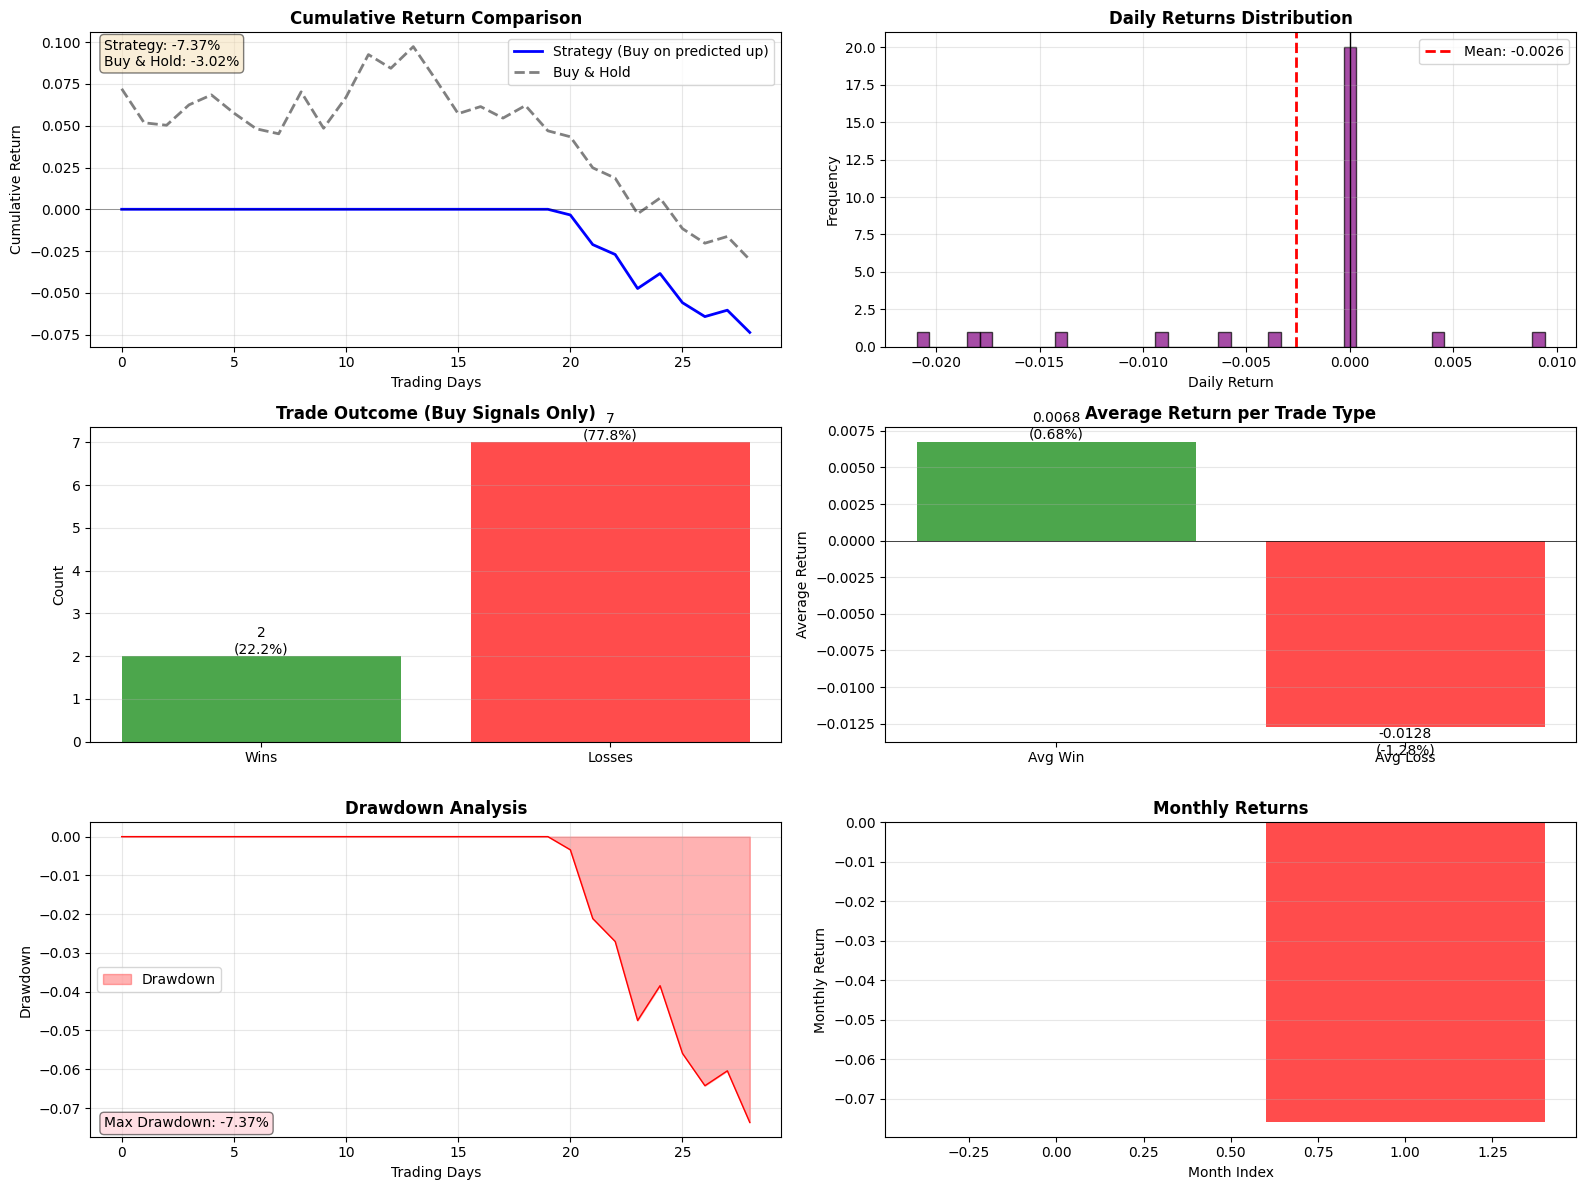


Backtest visualization complete!


In [16]:
# === シンプル・バックテスト（テスト区間のみ） ===
# ルール：
#   Buy(1) -> 翌日寄りで買って翌日引けで手仕舞い（= 翌日終値と当日終値の差分に連動すると仮定）
#   Sell(0) -> 何もしない（空売り等は考慮しないシンプル版）

test_close = test['close'].values
# ウィンドウ切り詰めに合わせて test_close を末尾1日分削る（y_test_reg と長さ一致）
test_close_tail = test_close[WINDOW_SIZE-1: -1]  # day_t close
test_close_next = test_close[WINDOW_SIZE:]       # day_{t+1} close

# 収益率（Buyのときのみリターンを計上）
ret = np.zeros_like(buy_pred_te, dtype=float)
price_diff = (test_close_next - test_close_tail) / (test_close_tail + 1e-9)  # 日次騰落率
ret[buy_pred_te == 1] = price_diff[buy_pred_te == 1]

cum_ret = (1 + ret).cumprod() - 1

# Buy and Holdのベンチマーク
buy_hold_ret = (test_close - test_close[0]) / test_close[0]
buy_hold_ret_aligned = buy_hold_ret[WINDOW_SIZE:]  # 長さを合わせる

print('='*60)
print('Backtest Results (Test Period)')
print('='*60)
print(f'Final Cumulative Return (Strategy): {cum_ret[-1]:.2%}')
print(f'Final Cumulative Return (Buy & Hold): {buy_hold_ret_aligned[-1]:.2%}')
print(f'Number of Trades (Buy signals): {buy_pred_te.sum()}')
print(f'Win Rate: {((ret > 0) & (buy_pred_te == 1)).sum() / max(buy_pred_te.sum(), 1):.2%}')
print(f'Average Return per Trade: {ret[buy_pred_te == 1].mean():.4f} ({ret[buy_pred_te == 1].mean()*100:.2f}%)')
print(f'Sharpe Ratio (approx): {(ret.mean() / (ret.std() + 1e-9)) * np.sqrt(252):.2f}')
print('='*60)

# === バックテストの詳細可視化 ===
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. 累積リターン（Strategy vs Buy & Hold）
ax1 = axes[0, 0]
ax1.plot(cum_ret, label='Strategy (Buy on predicted up)', linewidth=2, color='blue')
ax1.plot(buy_hold_ret_aligned, label='Buy & Hold', linewidth=2, color='gray', linestyle='--')
ax1.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
ax1.set_title('Cumulative Return Comparison', fontsize=12, fontweight='bold')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 最終リターンを表示
ax1.text(0.02, 0.98, f'Strategy: {cum_ret[-1]:.2%}\nBuy & Hold: {buy_hold_ret_aligned[-1]:.2%}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. 日次リターンの分布
ax2 = axes[0, 1]
ax2.hist(ret, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax2.axvline(ret.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ret.mean():.4f}')
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. トレード勝率（Buy信号のみ）
ax3 = axes[1, 0]
trade_returns = ret[buy_pred_te == 1]
wins = (trade_returns > 0).sum()
losses = (trade_returns <= 0).sum()
ax3.bar(['Wins', 'Losses'], [wins, losses], color=['green', 'red'], alpha=0.7)
ax3.set_title('Trade Outcome (Buy Signals Only)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Count')
for i, (label, val) in enumerate([('Wins', wins), ('Losses', losses)]):
    ax3.text(i, val, f'{val}\n({val/(wins+losses)*100:.1f}%)', 
             ha='center', va='bottom', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. 勝ちトレードと負けトレードの平均リターン
ax4 = axes[1, 1]
win_returns = trade_returns[trade_returns > 0]
loss_returns = trade_returns[trade_returns <= 0]
avg_win = win_returns.mean() if len(win_returns) > 0 else 0
avg_loss = loss_returns.mean() if len(loss_returns) > 0 else 0
ax4.bar(['Avg Win', 'Avg Loss'], [avg_win, avg_loss], color=['green', 'red'], alpha=0.7)
ax4.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax4.set_title('Average Return per Trade Type', fontsize=12, fontweight='bold')
ax4.set_ylabel('Average Return')
for i, (label, val) in enumerate([('Avg Win', avg_win), ('Avg Loss', avg_loss)]):
    ax4.text(i, val, f'{val:.4f}\n({val*100:.2f}%)', 
             ha='center', va='bottom' if val > 0 else 'top', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# 5. ドローダウン分析
ax5 = axes[2, 0]
cum_ret_series = pd.Series(cum_ret)
running_max = cum_ret_series.cummax()
drawdown = cum_ret_series - running_max
ax5.fill_between(range(len(drawdown)), 0, drawdown, color='red', alpha=0.3, label='Drawdown')
ax5.plot(drawdown, color='red', linewidth=1)
ax5.set_title('Drawdown Analysis', fontsize=12, fontweight='bold')
ax5.set_xlabel('Trading Days')
ax5.set_ylabel('Drawdown')
ax5.legend()
ax5.grid(True, alpha=0.3)

max_dd = drawdown.min()
ax5.text(0.02, 0.02, f'Max Drawdown: {max_dd:.2%}',
         transform=ax5.transAxes, fontsize=10, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='pink', alpha=0.5))

# 6. 月別リターン分析
ax6 = axes[2, 1]
# Test期間のインデックスを取得
test_indices = test.index[WINDOW_SIZE:]
if len(test_indices) == len(ret):
    ret_series = pd.Series(ret, index=test_indices)
    monthly_ret = ret_series.resample('M').sum()
    colors = ['green' if x > 0 else 'red' for x in monthly_ret]
    ax6.bar(range(len(monthly_ret)), monthly_ret.values, color=colors, alpha=0.7)
    ax6.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax6.set_title('Monthly Returns', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Month Index')
    ax6.set_ylabel('Monthly Return')
    ax6.grid(True, alpha=0.3, axis='y')
else:
    ax6.text(0.5, 0.5, 'Monthly returns\nnot available\n(index mismatch)',
             transform=ax6.transAxes, fontsize=12, ha='center', va='center')
    ax6.axis('off')

plt.tight_layout()
plt.show()

print("\nBacktest visualization complete!")

In [17]:
# === 保存物 ===
joblib.dump(scaler_X, 'scaler_X_7203T.joblib')
joblib.dump(scaler_y, 'scaler_y_7203T.joblib')
model_reg.save('model_regression_7203T.keras')

with open('params_7203T.txt', 'w', encoding='utf-8') as f:
    f.write(f'Ticker: {TICKER}\n')
    f.write(f'Period: {START_DATE}..{END_DATE}\n')
    f.write(f'Window: {WINDOW_SIZE}\n')
    f.write(f'Train end: {SPLIT_TRAIN_END}\nVal end: {SPLIT_VAL_END}\n')
    f.write(f'\nScalers:\n')
    f.write(f'  scaler_X: Feature scaler (StandardScaler)\n')
    f.write(f'  scaler_y: Target scaler (StandardScaler)\n')
    f.write(f'\nModel Performance:\n')
    f.write(f'  Test RMSE: {rmse(y_test_reg, pred_te):.4f}\n')
    f.write(f'  Test R²: {r2_score(y_test_reg, pred_te):.4f}\n')
    
print('Artifacts saved:')
print('  - scaler_X_7203T.joblib (feature scaler)')
print('  - scaler_y_7203T.joblib (target scaler)')
print('  - model_regression_7203T.keras (trained model)')
print('  - params_7203T.txt (parameters and metrics)')

Artifacts saved:
  - scaler_X_7203T.joblib (feature scaler)
  - scaler_y_7203T.joblib (target scaler)
  - model_regression_7203T.keras (trained model)
  - params_7203T.txt (parameters and metrics)


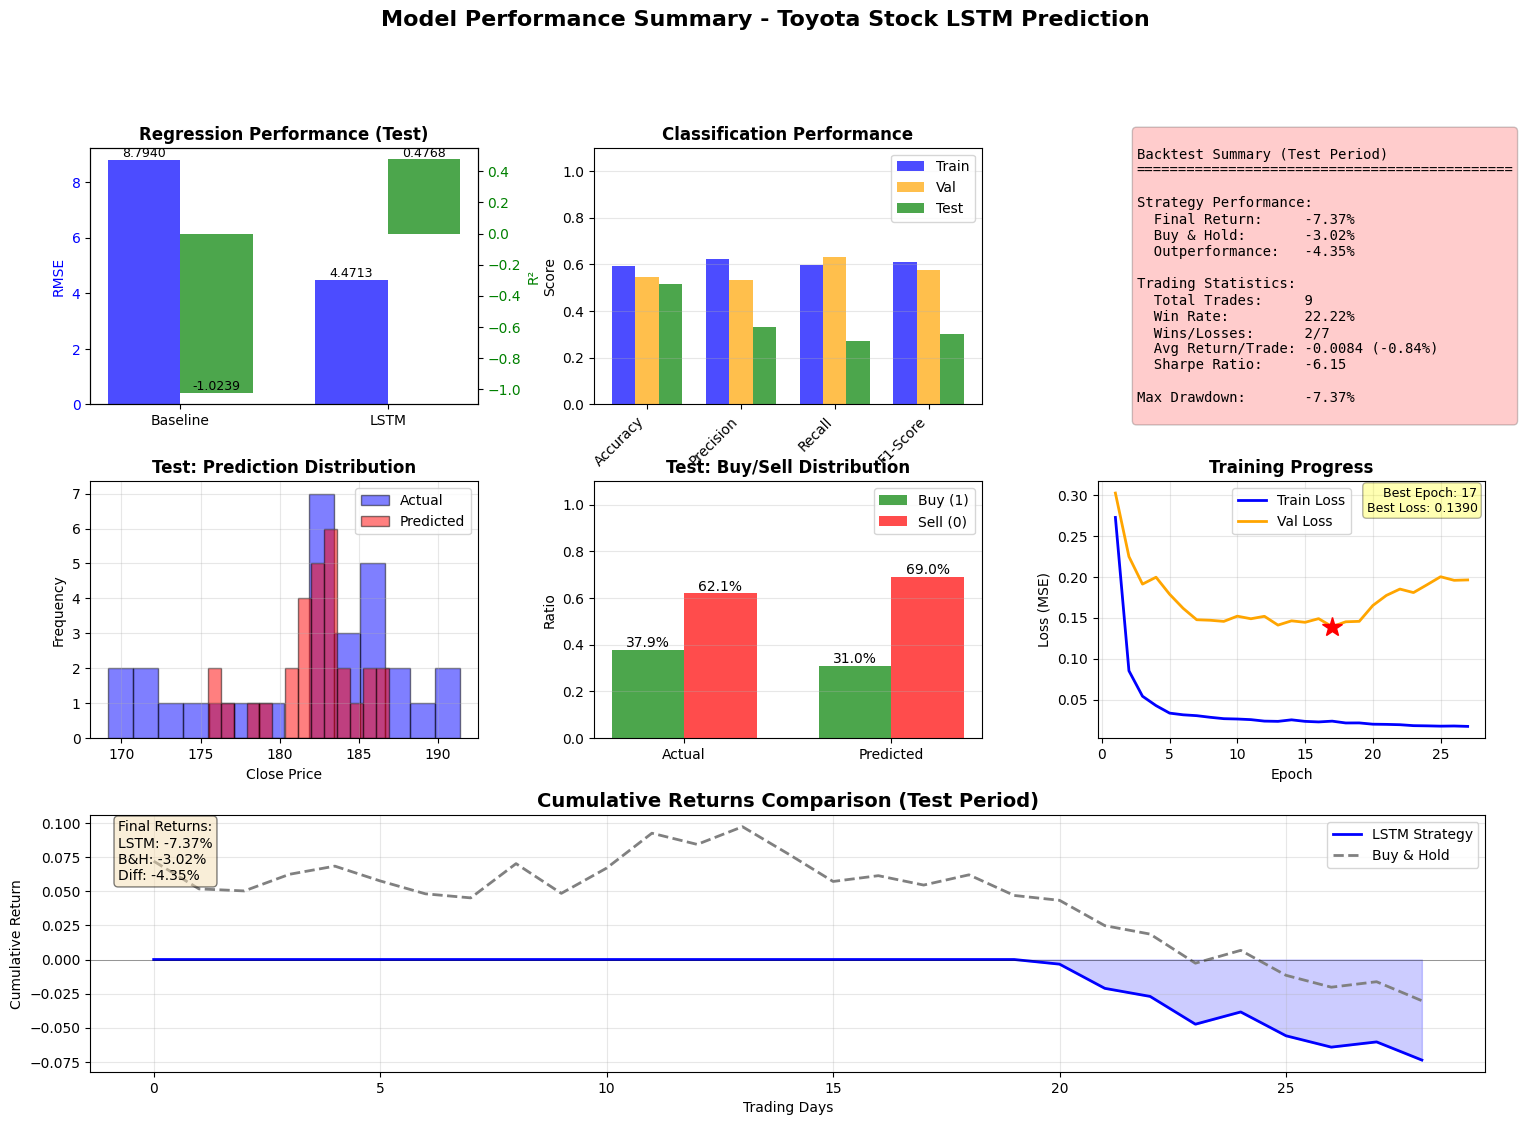


DIAGNOSTIC REPORT

1. Prediction Value Ranges:
   Test Actual Close:     min=169.15, max=191.40, mean=181.61
   Test Predicted Close:  min=175.46, max=186.90, mean=182.06
   Test Current Close:    min=170.88, max=193.97, mean=183.03

2. Buy/Sell Decision Analysis:
   Actual Buy signals:    11 (37.9%)
   Predicted Buy signals: 9 (31.0%)
   Pred - Current Close:  min=-7.0745, max=4.6125, mean=-0.9670
   Buy threshold check:   9 predictions above current close

3. Model Performance Summary:
   Regression RMSE:       4.4713
   Regression R²:         0.4768
   Classification Acc:    0.5172
   Classification F1:     0.3000

4. Recommendations:
   ✓ Buy signal rate is reasonable
   ✓ Regression R² is acceptable


In [18]:
# === モデル全体の精度サマリー可視化 ===
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. 回帰性能の総合比較（RMSE & R²）
ax1 = fig.add_subplot(gs[0, 0])
models = ['Baseline', 'LSTM']
test_rmse_vals = [rmse(y_test_reg, pred_te_bl), rmse(y_test_reg, pred_te)]
test_r2_vals = [r2_score(y_test_reg, pred_te_bl), r2_score(y_test_reg, pred_te)]

x = np.arange(len(models))
width = 0.35
bars1 = ax1.bar(x - width/2, test_rmse_vals, width, label='RMSE', color='blue', alpha=0.7)
ax1_twin = ax1.twinx()
bars2 = ax1_twin.bar(x + width/2, test_r2_vals, width, label='R²', color='green', alpha=0.7)

ax1.set_ylabel('RMSE', color='blue')
ax1_twin.set_ylabel('R²', color='green')
ax1.set_title('Regression Performance (Test)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.tick_params(axis='y', labelcolor='blue')
ax1_twin.tick_params(axis='y', labelcolor='green')

# 値を表示
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1_twin.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# 2. 分類性能の総合比較
ax2 = fig.add_subplot(gs[0, 1])
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_vals = [metrics_tr['acc'], metrics_tr['prec'], metrics_tr['rec'], metrics_tr['f1']]
val_vals = [metrics_v['acc'], metrics_v['prec'], metrics_v['rec'], metrics_v['f1']]
test_vals = [metrics_te['acc'], metrics_te['prec'], metrics_te['rec'], metrics_te['f1']]

x = np.arange(len(metric_names))
width = 0.25
ax2.bar(x - width, train_vals, width, label='Train', color='blue', alpha=0.7)
ax2.bar(x, val_vals, width, label='Val', color='orange', alpha=0.7)
ax2.bar(x + width, test_vals, width, label='Test', color='green', alpha=0.7)

ax2.set_ylabel('Score')
ax2.set_title('Classification Performance', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metric_names, rotation=45, ha='right')
ax2.set_ylim(0, 1.1)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. バックテスト性能サマリー
ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')

# バックテスト統計を取得
n_trades = buy_pred_te.sum()
if n_trades > 0:
    trade_returns = ret[buy_pred_te == 1]
    wins = (trade_returns > 0).sum()
    win_rate = wins / n_trades
    avg_return = trade_returns.mean()
else:
    win_rate = 0
    avg_return = 0
    wins = 0

sharpe = (ret.mean() / (ret.std() + 1e-9)) * np.sqrt(252)

backtest_text = f"""
Backtest Summary (Test Period)
{'='*45}

Strategy Performance:
  Final Return:     {cum_ret[-1]:.2%}
  Buy & Hold:       {buy_hold_ret_aligned[-1]:.2%}
  Outperformance:   {(cum_ret[-1] - buy_hold_ret_aligned[-1]):.2%}

Trading Statistics:
  Total Trades:     {n_trades}
  Win Rate:         {win_rate:.2%}
  Wins/Losses:      {wins}/{n_trades - wins if n_trades > 0 else 0}
  Avg Return/Trade: {avg_return:.4f} ({avg_return*100:.2f}%)
  Sharpe Ratio:     {sharpe:.2f}

Max Drawdown:       {drawdown.min():.2%}
"""

color = 'green' if cum_ret[-1] > buy_hold_ret_aligned[-1] else 'red'
ax3.text(0.1, 0.5, backtest_text, fontsize=10, family='monospace',
         verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor=color, alpha=0.2))

# 4. 予測値の分布（Test）
ax4 = fig.add_subplot(gs[1, 0])
# bins数を動的に調整
n_bins = min(20, max(5, len(np.unique(y_test_reg)) // 2))
ax4.hist(y_test_reg, bins=n_bins, alpha=0.5, label='Actual', color='blue', edgecolor='black')
ax4.hist(pred_te, bins=n_bins, alpha=0.5, label='Predicted', color='red', edgecolor='black')
ax4.set_title('Test: Prediction Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Close Price')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Buy/Sell予測の分布
ax5 = fig.add_subplot(gs[1, 1])
actual_buy_pct = y_test_cls.mean()
pred_buy_pct = buy_pred_te.mean()

categories = ['Actual', 'Predicted']
buy_pcts = [actual_buy_pct, pred_buy_pct]
sell_pcts = [1 - actual_buy_pct, 1 - pred_buy_pct]

x = np.arange(len(categories))
width = 0.35
bars1 = ax5.bar(x - width/2, buy_pcts, width, label='Buy (1)', color='green', alpha=0.7)
bars2 = ax5.bar(x + width/2, sell_pcts, width, label='Sell (0)', color='red', alpha=0.7)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center', va='bottom', fontsize=10)

ax5.set_ylabel('Ratio')
ax5.set_title('Test: Buy/Sell Distribution', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(categories)
ax5.legend()
ax5.set_ylim(0, 1.1)
ax5.grid(True, alpha=0.3, axis='y')

# 6. 学習曲線（最終エポック）
ax6 = fig.add_subplot(gs[1, 2])
final_epoch = len(hist.history['loss'])
epochs_range = range(1, final_epoch + 1)
ax6.plot(epochs_range, hist.history['loss'], label='Train Loss', linewidth=2, color='blue')
ax6.plot(epochs_range, hist.history['val_loss'], label='Val Loss', linewidth=2, color='orange')
min_val_loss_epoch = np.argmin(hist.history['val_loss'])
min_val_loss = hist.history['val_loss'][min_val_loss_epoch]
ax6.plot(min_val_loss_epoch + 1, min_val_loss, 'r*', markersize=15)
ax6.set_title('Training Progress', fontsize=12, fontweight='bold')
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Loss (MSE)')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.text(0.98, 0.98, f'Best Epoch: {min_val_loss_epoch + 1}\nBest Loss: {min_val_loss:.4f}',
         transform=ax6.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# 7. 累積リターンの比較
ax7 = fig.add_subplot(gs[2, :])
ax7.plot(cum_ret, label='LSTM Strategy', linewidth=2, color='blue')
ax7.plot(buy_hold_ret_aligned, label='Buy & Hold', linewidth=2, color='gray', linestyle='--')
ax7.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
ax7.fill_between(range(len(cum_ret)), 0, cum_ret, alpha=0.2, color='blue')
ax7.set_title('Cumulative Returns Comparison (Test Period)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Trading Days')
ax7.set_ylabel('Cumulative Return')
ax7.legend(loc='best')
ax7.grid(True, alpha=0.3)

# 最終リターンを表示
final_ret_text = f'Final Returns:\nLSTM: {cum_ret[-1]:.2%}\nB&H: {buy_hold_ret_aligned[-1]:.2%}\nDiff: {(cum_ret[-1] - buy_hold_ret_aligned[-1]):.2%}'
ax7.text(0.02, 0.98, final_ret_text,
         transform=ax7.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Model Performance Summary - Toyota Stock LSTM Prediction', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# === 問題診断 ===
print('\n' + '='*70)
print('DIAGNOSTIC REPORT')
print('='*70)

# 1. 予測値の範囲チェック
print('\n1. Prediction Value Ranges:')
print(f'   Test Actual Close:     min={y_test_reg.min():.2f}, max={y_test_reg.max():.2f}, mean={y_test_reg.mean():.2f}')
print(f'   Test Predicted Close:  min={pred_te.min():.2f}, max={pred_te.max():.2f}, mean={pred_te.mean():.2f}')
print(f'   Test Current Close:    min={close_test_tail.min():.2f}, max={close_test_tail.max():.2f}, mean={close_test_tail.mean():.2f}')

# 2. Buy/Sell判定の詳細
print('\n2. Buy/Sell Decision Analysis:')
print(f'   Actual Buy signals:    {int(y_test_cls.sum())} ({y_test_cls.mean():.1%})')
print(f'   Predicted Buy signals: {int(buy_pred_te.sum())} ({buy_pred_te.mean():.1%})')
price_diff_pred = pred_te - close_test_tail
print(f'   Pred - Current Close:  min={price_diff_pred.min():.4f}, max={price_diff_pred.max():.4f}, mean={price_diff_pred.mean():.4f}')
print(f'   Buy threshold check:   {(pred_te > close_test_tail).sum()} predictions above current close')

# 3. モデル性能サマリー
print('\n3. Model Performance Summary:')
print(f'   Regression RMSE:       {rmse(y_test_reg, pred_te):.4f}')
print(f'   Regression R²:         {r2_score(y_test_reg, pred_te):.4f}')
print(f'   Classification Acc:    {metrics_te["acc"]:.4f}')
print(f'   Classification F1:     {metrics_te["f1"]:.4f}')

# 4. 推奨事項
print('\n4. Recommendations:')
if buy_pred_te.sum() == 0:
    print('   ⚠️  WARNING: No Buy signals generated!')
    print('   - Model is predicting prices below or equal to current close')
    print('   - Possible causes:')
    print('     * Test period may have downward trend')
    print('     * Model is overly conservative')
    print('     * Feature scaling or window size needs adjustment')
    print('   - Suggested actions:')
    print('     * Increase training epochs or adjust model architecture')
    print('     * Try different window sizes (e.g., 20 or 50 instead of 30)')
    print('     * Add more diverse features or use different technical indicators')
elif buy_pred_te.mean() < 0.3:
    print('   ⚠️  Low Buy signal rate detected')
    print('   - Model is conservative in Buy predictions')
    print('   - Consider threshold adjustment for more trading opportunities')
else:
    print('   ✓ Buy signal rate is reasonable')

if r2_score(y_test_reg, pred_te) < 0.3:
    print('   ⚠️  Low R² score indicates poor prediction accuracy')
    print('   - Consider more training data, feature engineering, or model tuning')
elif r2_score(y_test_reg, pred_te) < 0:
    print('   ⚠️  Negative R² score - model performs worse than baseline!')
    print('   - Model is not capturing the pattern in test data')
    print('   - Test period characteristics may differ significantly from training')
else:
    print('   ✓ Regression R² is acceptable')

print('='*70)

## ノートブックの構成

### データ読み込み
- ローカルCSVファイルから直接データを取得
- 日付インデックスの正規化と数値型への変換
- 2020/09〜2025/06の期間をフィルタリング

### 特徴量エンジニアリング
- テクニカル指標の計算（RSI, MACD, ボリンジャーバンド、移動平均）
- リターン、出来高変化率などの派生特徴量
- 翌日終値予測（回帰）とBuy/Sell判定（分類）のターゲット変数を生成

### モデリング
- 時系列分割（Train/Val/Test）
- ベースライン：線形回帰
- メインモデル：LSTM（回帰）→ 分類ラベル生成

### 評価と可視化
- 回帰：RMSE / R²
- 分類：Accuracy / Precision / Recall / F1、Confusion Matrix
- バックテスト：累積リターン、勝率、ドローダウン分析
- 包括的なグラフによる多角的分析